<a href="https://colab.research.google.com/github/micah-shull/loan_defaults/blob/main/loan_defaults_016_feature_selection_filter_methods_RF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Data Description

This dataset contains information on clients' credit card behavior, provided by a financial institution in Taiwan. The target variable is `default_payment_next_month`, which indicates whether the client defaulted on their credit card payment the next month.

url = https://archive.ics.uci.edu/dataset/350/default+of+credit+card+clients

#### Variables:

- **ID**: ID of each client.
- **LIMIT_BAL**: Amount of given credit in NT dollars (includes individual and family/supplementary credit).
- **SEX**: Gender (1 = male, 2 = female).
- **EDUCATION**: Education level (1 = graduate school, 2 = university, 3 = high school, 4 = others, 5 = unknown, 6 = unknown).
- **MARRIAGE**: Marital status (1 = married, 2 = single, 3 = others).
- **AGE**: Age in years.

#### Payment History (PAY_X):
- **PAY_0**: Repayment status in September 2005 (-1 = pay duly, 1 = payment delay for one month, 2 = payment delay for two months, ... 8 = payment delay for eight months, 9 = payment delay for nine months and above).
- **PAY_2**: Repayment status in August 2005.
- **PAY_3**: Repayment status in July 2005.
- **PAY_4**: Repayment status in June 2005.
- **PAY_5**: Repayment status in May 2005.
- **PAY_6**: Repayment status in April 2005.

#### Bill Statement Amount (BILL_AMT_X):
- **BILL_AMT1**: Amount of bill statement in September 2005 (NT dollars).
- **BILL_AMT2**: Amount of bill statement in August 2005 (NT dollars).
- **BILL_AMT3**: Amount of bill statement in July 2005 (NT dollars).
- **BILL_AMT4**: Amount of bill statement in June 2005 (NT dollars).
- **BILL_AMT5**: Amount of bill statement in May 2005 (NT dollars).
- **BILL_AMT6**: Amount of bill statement in April 2005 (NT dollars).

#### Previous Payment Amount (PAY_AMT_X):
- **PAY_AMT1**: Amount of previous payment in September 2005 (NT dollars).
- **PAY_AMT2**: Amount of previous payment in August 2005 (NT dollars).
- **PAY_AMT3**: Amount of previous payment in July 2005 (NT dollars).
- **PAY_AMT4**: Amount of previous payment in June 2005 (NT dollars).
- **PAY_AMT5**: Amount of previous payment in May 2005 (NT dollars).
- **PAY_AMT6**: Amount of previous payment in April 2005 (NT dollars).

- **default_payment_next_month**: Default payment indicator (1 = yes, 0 = no).

#### Explanation for Feature Reordering:
The bill statement and payment amounts are listed in reverse chronological order in the dataset. To ensure that the feature names match the actual sequence of events, we reverse the column names for `BILL_AMT` and `PAY_AMT` features so that they correctly represent the time sequence from April 2005 to September 2005.



## Load & Preprocess Data

Missing Values: 0
Missing Percentage: 0.0
Number of Duplicate Rows: 0

<class 'pandas.core.frame.DataFrame'>
Index: 29965 entries, 0 to 29999
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   limit_bal                   29965 non-null  int64   
 1   sex                         29965 non-null  category
 2   education                   29965 non-null  category
 3   marriage                    29965 non-null  category
 4   age                         29965 non-null  int64   
 5   bill_amt_4_april            29965 non-null  int64   
 6   bill_amt_5_may              29965 non-null  int64   
 7   bill_amt_6_june             29965 non-null  int64   
 8   bill_amt_7_july             29965 non-null  int64   
 9   bill_amt_8_august           29965 non-null  int64   
 10  bill_amt_9_september        29965 non-null  int64   
 11  pay_amt_4_april             29965 non-null  int64   
 12  pay_amt_

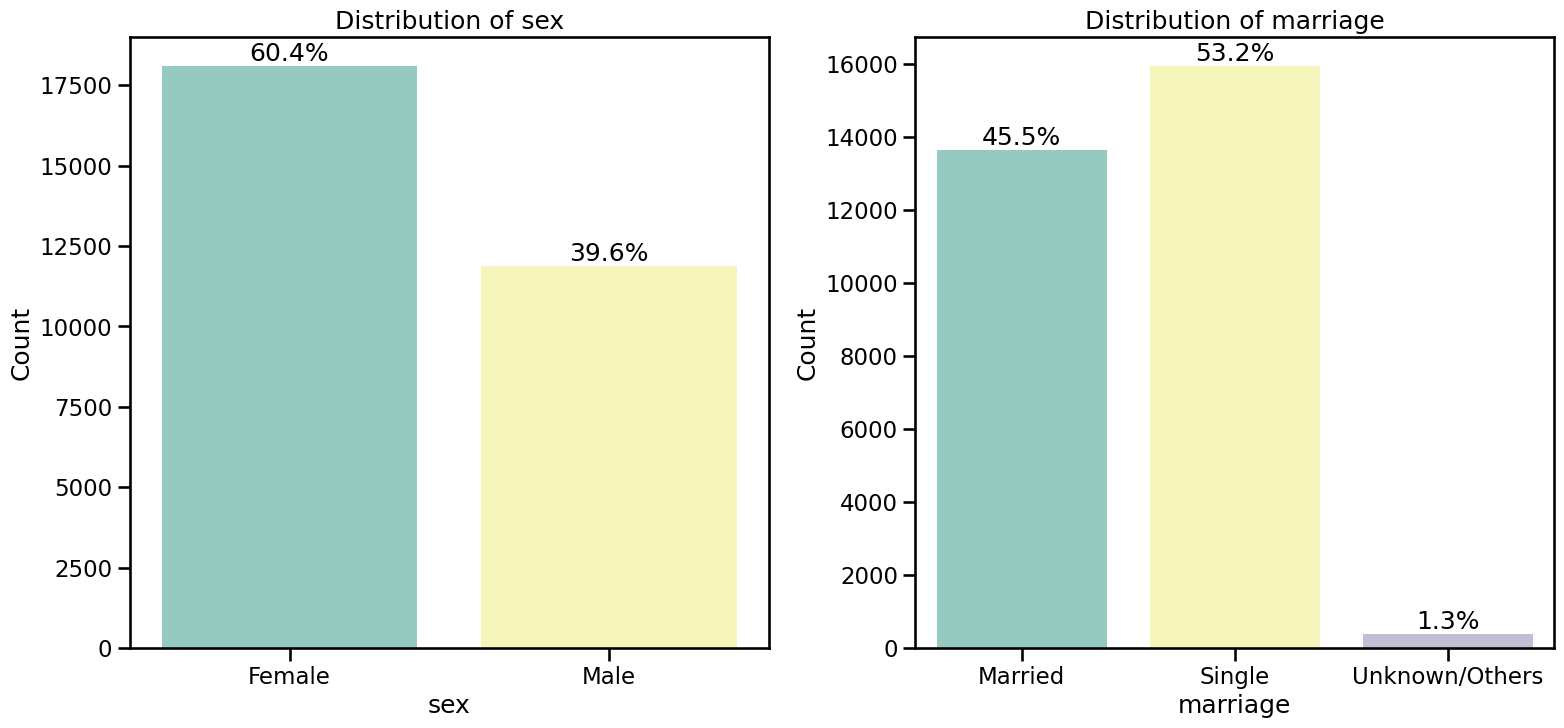

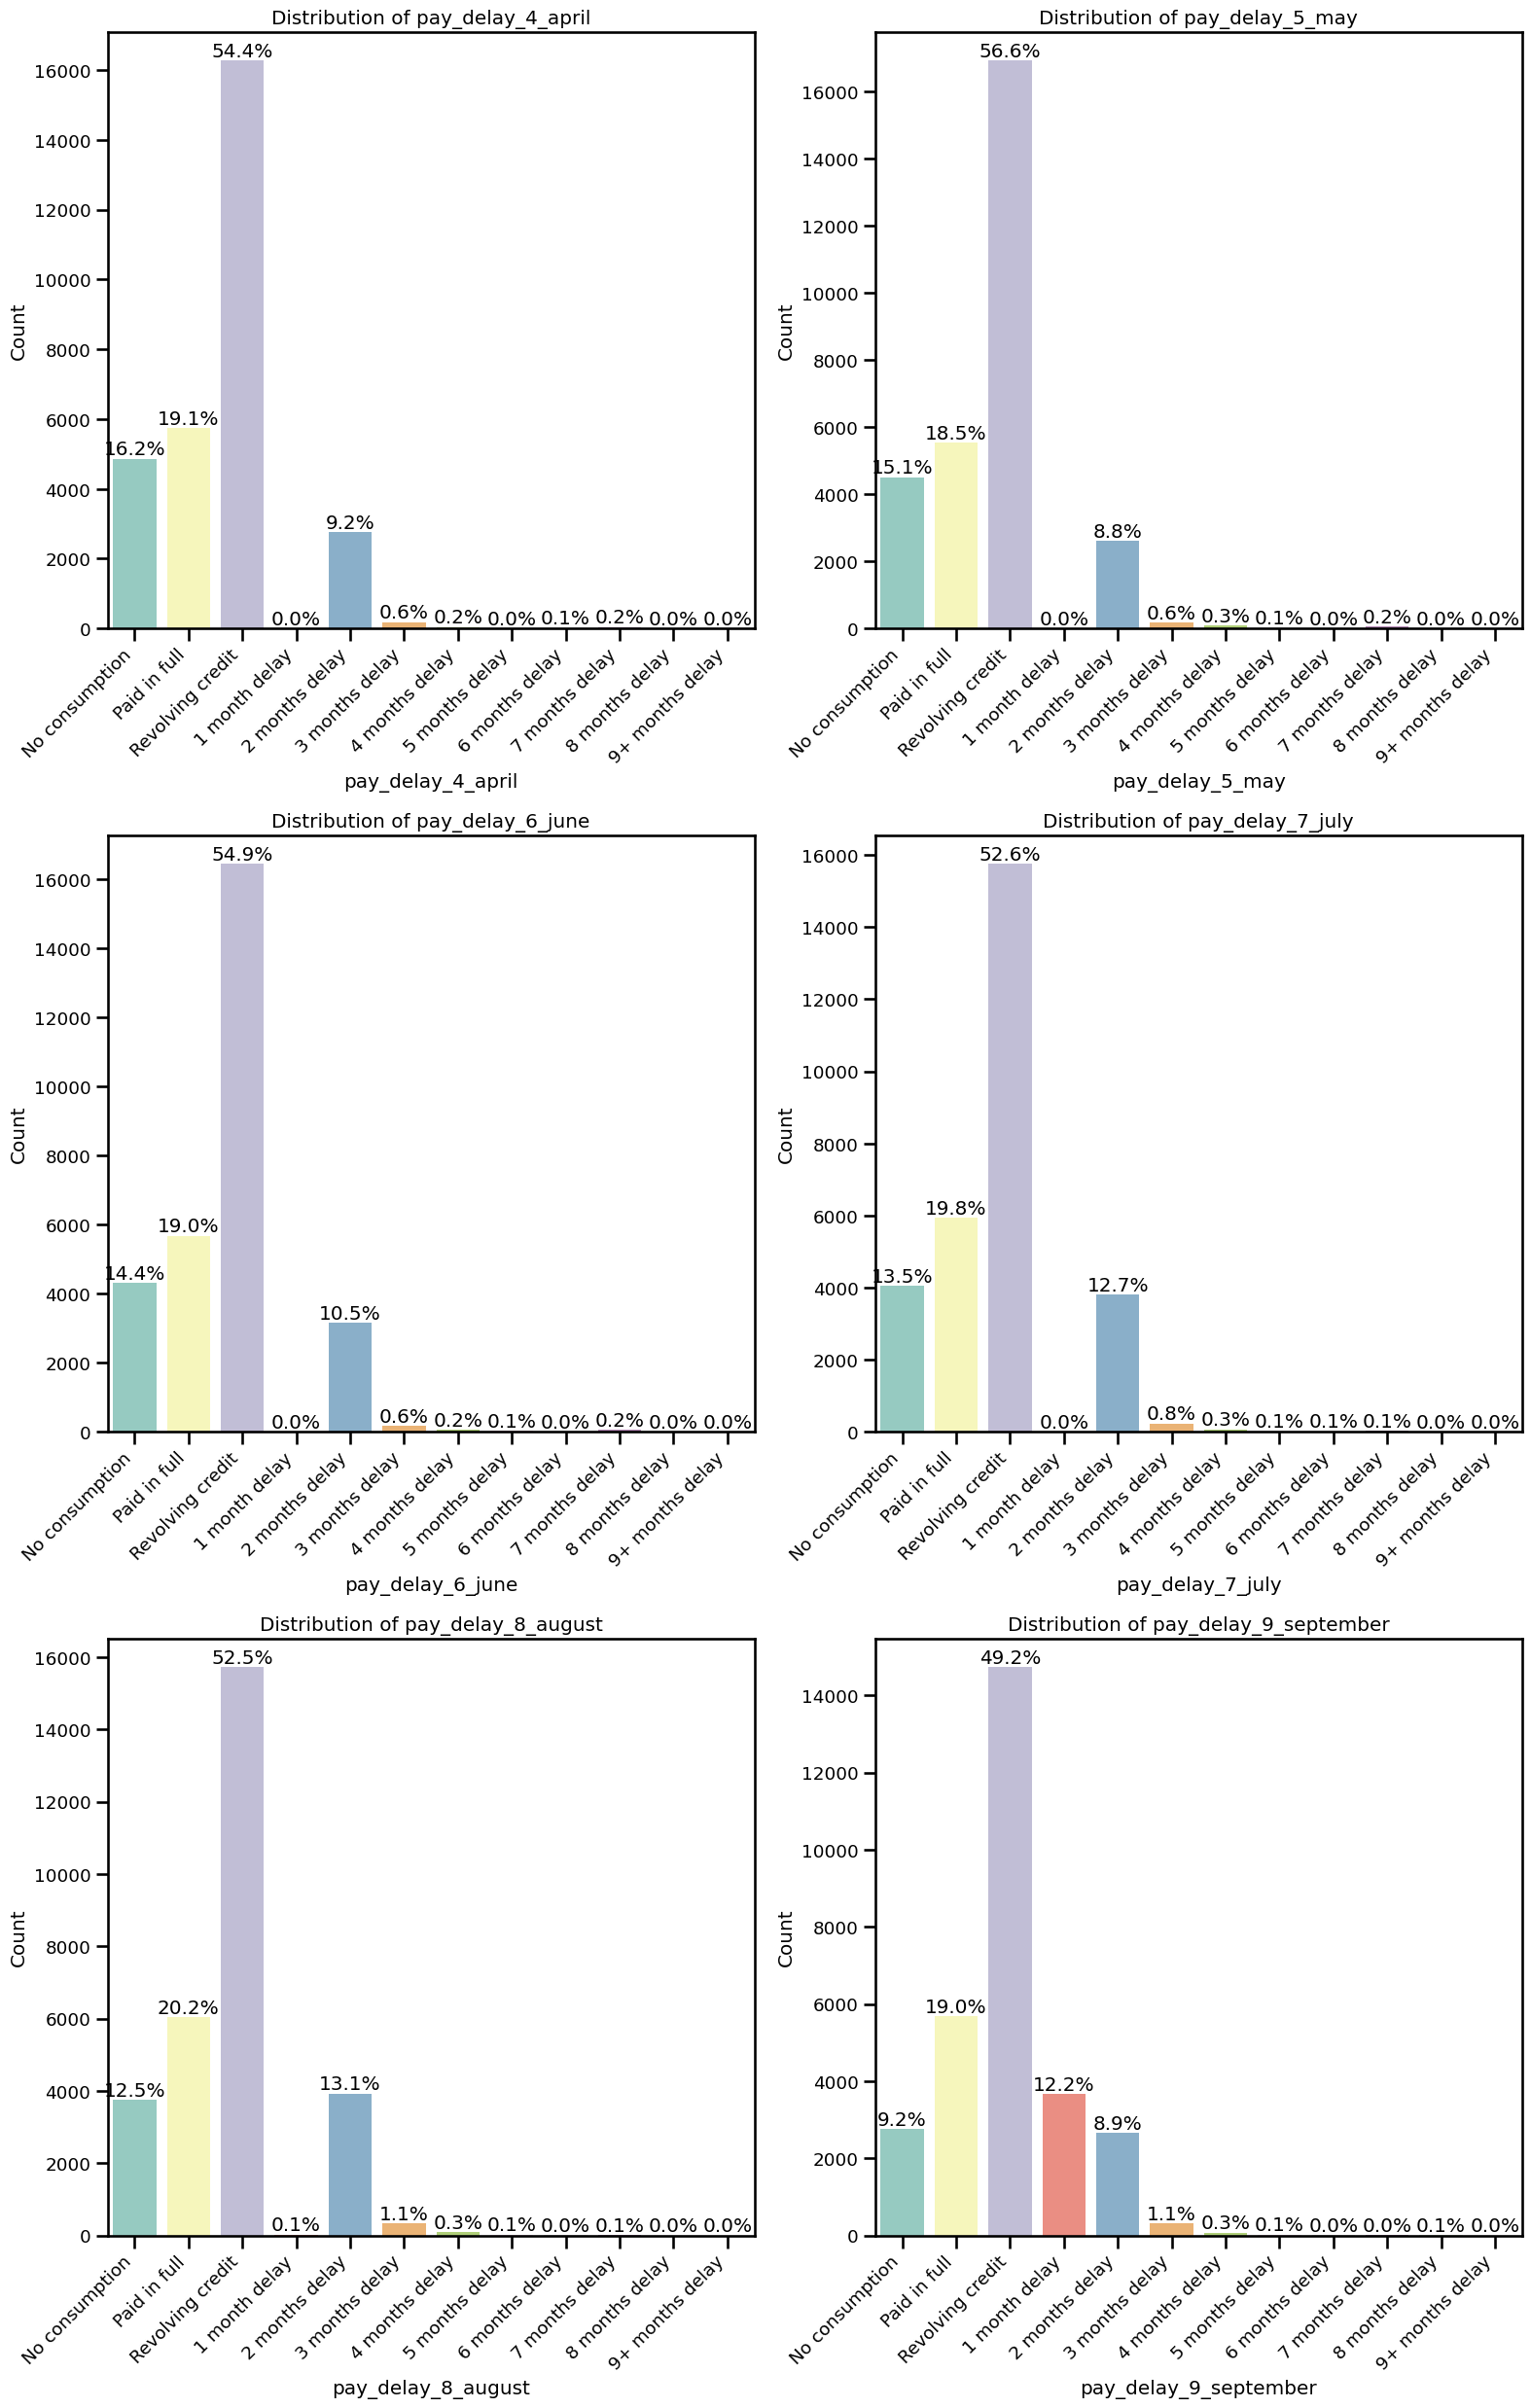

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from loan_data_utils import (load_data_from_url, clean_column_names, remove_id_column, rename_pay_columns, rename_bill_and_payment_columns,load_and_preprocess_data,
                             label_pay_columns, convert_pay_columns_to_ordinal, reorder_columns, convert_education_to_ordinal, process_sex_column, process_sex_column_cat_codes_one_two,
                             process_marriage_column, process_default_payment_column, convert_ordinal_to_category, check_column_integrity, validate_data_types,
                             check_categorical_order, primary_columns, bill_columns, pay_columns, ordinal_columns, categorical_columns,
                             plot_categorical_distributions, plot_ordinal_distributions)
from eda_utils import data_overview, plot_univariate_distributions, plot_class_distribution
import logging

# Define your URL, categorical columns, and target
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"
categorical_columns = ['sex', 'marriage']
target = 'default_payment_next_month'

# Now, load the data
df = load_and_preprocess_data(url, categorical_columns, target)

if df is not None:
    # Ensure the target column is treated as a categorical variable
    df[target] = df[target].astype('category')

    # Print data overview
    data_overview(df)

    # Drop duplicate rows (optional if you didn’t remove them earlier)
    df = df.drop_duplicates()

    # Confirm the duplicates are removed
    print(f"Number of Duplicate Rows After Dropping: {df.duplicated().sum()}")

    # List of columns to check
    pay_cols = [col for col in df.columns if col.startswith('pay_delay')]

    # Check the order of categorical columns
    check_categorical_order(df, categorical_columns + pay_cols + [target])
else:
    print("Error loading and preprocessing data.")

# Convert Target to Categorical
df[target] = df[target].cat.codes  # Convert to categorical codes (0, 1)
# Check the results
print('Target converted to numeric')
print(df[target].unique())  # Should output [0, 1]

# visualize the categorical data
plot_categorical_distributions(df, categorical_columns)
plot_ordinal_distributions(df, ordinal_columns)

## SMOTE Pipeline Data
Having all the columns as floats and scaled is generally what you want for feature selection. Here's why:

1. **Float Representation**: Feature selection methods, especially those based on statistical tests or model-based approaches, typically work best when all the features are numerical. Since all your categorical, ordinal, and boolean features have been encoded as numeric types (floats), it makes it easier to apply feature selection algorithms consistently.

2. **Scaling**: Many feature selection methods, such as those based on model coefficients (like Lasso or Ridge regression), are sensitive to the scale of the data. By scaling the features, you're ensuring that all features are treated equally during selection, regardless of their original units or ranges. This helps the selection methods better evaluate the importance of each feature.

### For Feature Selection:
- **Univariate Methods**: Methods like `SelectKBest` with ANOVA or chi-squared tests benefit from numeric, scaled data.
- **Model-Based Selection**: Approaches using models like Lasso or Ridge require scaled numeric data for optimal performance.
- **Embedded Methods**: Methods that use tree-based models or gradient boosting can still work without scaling but will perform consistently across different features when scaling is applied.

In short, having all columns as floats and scaled is ideal for the majority of feature selection techniques. You're set up well to proceed with feature selection!


### Process Train & Test Data

In [11]:
# Import the necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from imblearn.pipeline import Pipeline as IMBPipeline
from imblearn.over_sampling import SMOTE
from loan_data_utils import ThresholdClassifier
from feature_engineering_pipeline_utils import (HighRiskDelayFeatureTransformer, SevereDelayCountTransformer,
                                                CumulativeDelayTransformer, SevereDelayPaymentRatioTransformer,
                                                AvgPaymentSevereDelaysTransformer, DeferredAndDecreasingPaymentsTransformer,
                                                SevereDeferredAndDecreasingPaymentsTransformer, SevereDeferredAndAnyDecreasingPaymentsTransformer,
                                                TotalPaymentsTransformer, AvgPaymentTransformer, PaymentStdTransformer, WeightedPaymentSumTransformer,
                                                TotalBillsTransformer, DebtToLimitRatioTransformer, EducationMarriageInteractionTransformer,
                                                WinsorRobustOutlierRemovalTransformer, CombinedFeatureEngineeringTransformer)

# Define the target
target = 'default_payment_next_month'

# Split the data into features and target
X = df.drop(columns=[target])
y = df[target]

# Perform the train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Define the columns (numeric, categorical, ordinal, boolean)
numeric_features = ['age', 'limit_bal', 'bill_amt_4_april', 'bill_amt_5_may', 'bill_amt_6_june',
                    'bill_amt_7_july', 'bill_amt_8_august', 'bill_amt_9_september', 'pay_amt_4_april',
                    'pay_amt_5_may', 'pay_amt_6_june', 'pay_amt_7_july', 'pay_amt_8_august', 'pay_amt_9_september',
                    'severe_delay_count', 'cumulative_delay', 'severe_delay_payment_ratio', 'avg_payment_severe_delays',
                    'total_payments', 'avg_payment', 'payment_std', 'weighted_payment_sum', 'total_bills', 'debt_to_limit_ratio']
pay_columns = ['pay_amt_4_april', 'pay_amt_5_may','pay_amt_6_june', 'pay_amt_7_july','pay_amt_8_august', 'pay_amt_9_september',
               'bill_amt_4_april', 'bill_amt_5_may','bill_amt_6_june', 'bill_amt_7_july','bill_amt_8_august', 'bill_amt_9_september']
delay_columns = ['pay_delay_4_april', 'pay_delay_5_may', 'pay_delay_6_june', 'pay_delay_7_july', 'pay_delay_8_august', 'pay_delay_9_september']
bill_columns = ['bill_amt_4_april', 'bill_amt_5_may', 'bill_amt_6_june', 'bill_amt_7_july', 'bill_amt_8_august', 'bill_amt_9_september']
categorical_features = ['sex', 'marriage', 'education_marriage']
ordinal_features = ['education', 'pay_delay_4_april', 'pay_delay_5_may', 'pay_delay_6_june', 'pay_delay_7_july', 'pay_delay_8_august', 'pay_delay_9_september']
boolean_features = ['high_risk_delay', 'deferred_and_decreasing_payments', 'severe_deferred_and_decreasing_payments', 'severe_deferred_and_any_decreasing_payments']

# Step 1: Feature Engineering and Preprocessing Pipeline
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

ordinal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

bool_to_numeric_transformer = Pipeline(steps=[
    ('convert_bool', FunctionTransformer(lambda x: x.astype(int))),
    ('imputer', SimpleImputer(strategy='most_frequent'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
        ('ord', ordinal_transformer, ordinal_features),
        ('bool', bool_to_numeric_transformer, boolean_features)
    ]
)

# Step 1: Define the full pipeline (with SMOTE) for the training data
smote_preprocessing_pipeline = IMBPipeline(steps=[
    ('outlier_removal', WinsorRobustOutlierRemovalTransformer(columns=pay_columns)),  # Outlier removal
    ('feature_engineering', CombinedFeatureEngineeringTransformer(delay_columns, pay_columns, bill_columns)),  # Feature engineering
    ('preprocessor', preprocessor),  # Preprocessing
    ('smote', SMOTE(random_state=42))  # SMOTE for resampling
])

# Step 2: Define the preprocessing pipeline for the test data (without SMOTE)
test_preprocessing_pipeline = Pipeline(steps=[
    ('outlier_removal', WinsorRobustOutlierRemovalTransformer(columns=pay_columns)),  # Outlier removal
    ('feature_engineering', CombinedFeatureEngineeringTransformer(delay_columns, pay_columns, bill_columns)),  # Feature engineering
    ('preprocessor', preprocessor)  # Preprocessing (without SMOTE)
])

# Step 3: Fit the training pipeline and resample the training data
X_train_processed, y_train_resampled = smote_preprocessing_pipeline.fit_resample(X_train, y_train)

# Step 4: Fit the test preprocessing pipeline using the training data
# We need to fit the test pipeline on X_train to ensure that scaling and encoding parameters are learned from the training set
test_preprocessing_pipeline.fit(X_train)

# Step 5: Transform the test data using the test preprocessing pipeline
X_test_processed = test_preprocessing_pipeline.transform(X_test)

# Step 6: Manually Construct Feature Names
# Numeric features (after imputation and scaling)
numeric_feature_names = smote_preprocessing_pipeline.named_steps['preprocessor'].transformers_[0][1].get_feature_names_out(numeric_features)

# Categorical features (after OneHotEncoder)
categorical_feature_names = smote_preprocessing_pipeline.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(categorical_features)

# Ordinal features (no changes, just the original names)
ordinal_feature_names = ordinal_features

# Boolean features (manually handled as they are converted to 0/1)
boolean_feature_names = boolean_features

# Combine all feature names into a single list
all_feature_names = np.concatenate([numeric_feature_names, categorical_feature_names, ordinal_feature_names, boolean_feature_names])

# Step 7: Convert the processed training and test data to DataFrames with meaningful feature names
X_train_processed_df = pd.DataFrame(X_train_processed, columns=all_feature_names)
X_test_processed_df = pd.DataFrame(X_test_processed, columns=all_feature_names)

# Step 8: Add the target variable to the training DataFrame (y_train_resampled) and test DataFrame (y_test)
X_train_processed_df['target'] = y_train_resampled
X_test_processed_df['target'] = y_test  # We don't resample y_test

# Optional: check the data types to confirm everything is as expected
print("Data types after processing (X_train):")
print(X_train_processed_df.dtypes)
print("Data types after processing (X_test):")
print(X_test_processed_df.dtypes)

# Step 9: Inspect the processed DataFrames for feature selection
print("Processed training data ready for feature selection:")
X_train_processed_df.head()
print("Processed test data ready for feature selection:")
X_test_processed_df.head()

# Step 10: (Optional) Save the processed DataFrames for feature selection
X_train_processed_df.to_csv('X_train_processed.csv', index=False)
X_test_processed_df.to_csv('X_test_processed.csv', index=False)

# Confirmation of saved processed data
print("Processed train and test data saved for feature selection.")


Data types after processing (X_train):
age                                                  float64
limit_bal                                            float64
bill_amt_4_april                                     float64
bill_amt_5_may                                       float64
bill_amt_6_june                                      float64
bill_amt_7_july                                      float64
bill_amt_8_august                                    float64
bill_amt_9_september                                 float64
pay_amt_4_april                                      float64
pay_amt_5_may                                        float64
pay_amt_6_june                                       float64
pay_amt_7_july                                       float64
pay_amt_8_august                                     float64
pay_amt_9_september                                  float64
severe_delay_count                                   float64
cumulative_delay                              

### Filter Methods
You're right that the Chi-Square test is typically used for categorical data and can't be directly applied to numeric features. However, for numeric data, you have several other filter-based feature selection methods to consider. Some common ones include:

### 1. **Variance Threshold**:
   Removes features with low variance (i.e., features that don't vary much and may not be informative).

### 2. **Correlation Matrix (Pearson’s Correlation)**:
   Computes the pairwise correlation between features and removes highly correlated ones to reduce multicollinearity.

### 3. **ANOVA F-test**:
   This is similar to Chi-Square but works with continuous features to measure the relationship between features and target.

### 4. **Mutual Information**:
   Measures how much information the presence of one feature gives about the target variable.





Using **Random Forest (RF)** for feature importance is valuable because of the way it builds its model and assesses the contribution of each feature in a straightforward, interpretable manner. Here's why Random Forest is often preferred for feature importance and how it fits into the goals of **interpretability** and **model simplicity**:

### **Why Random Forest is Valuable for Feature Importance:**
1. **Ensemble of Decision Trees**:
   - Random Forest is an ensemble learning method that creates multiple decision trees using different subsets of the data and features, then averages their predictions. This reduces the risk of overfitting and provides more stable feature importance scores compared to a single decision tree.
   
2. **Feature Importance Calculation**:
   - **Gini Importance (Mean Decrease in Impurity)**: RF computes feature importance based on how much each feature reduces the **Gini impurity** or **entropy** in the trees. Features that split the data effectively (i.e., create "pure" subsets with less class mixing) are considered more important.
   - **Mean Decrease in Accuracy**: RF can also measure the importance of each feature by assessing how much the model's accuracy decreases when a feature is randomly permuted. If removing or shuffling a feature significantly impacts model performance, it’s a strong indicator of that feature’s importance.

3. **Handling of Data Characteristics**:
   - **Non-Linear Relationships**: Random Forest can naturally capture non-linear relationships between features and the target variable, meaning that it can find complex interactions between features that may not be apparent in simpler models.
   - **Handling Missing Data and Imbalanced Data**: RF can handle missing data, high-dimensional data, and imbalanced datasets fairly well, without requiring much preprocessing. This makes it a practical and straightforward approach for feature importance.

4. **Stability of Feature Importance**:
   - Since Random Forest is based on an ensemble of trees, the importance scores are more stable than those from individual decision trees, which are sensitive to small changes in the data.

### **Why Random Forest is a Good Choice for Interpretability and Model Simplicity**:
1. **Feature Interpretability**:
   - The feature importance scores from RF are easy to interpret. For each feature, you can see a straightforward score that reflects how much the feature contributes to reducing uncertainty or improving the model's prediction accuracy. This makes it clear which features are the most influential.
   - By ranking features based on their importance, you can focus on the most important features in your data, helping to better understand which aspects of the data drive the predictions.

2. **Model Simplicity**:
   - Although RF uses many trees, the individual decision trees are simple and easy to understand. This makes the model more interpretable than other complex models like gradient boosting or deep learning models.
   - Each decision tree is based on if-then-else rules, which are inherently interpretable, allowing you to understand how certain features lead to specific predictions.

3. **Feature Selection**:
   - By using the importance scores from Random Forest, you can perform **feature selection** in a principled way. You can eliminate less important features, reducing the complexity of the dataset while maintaining predictive power, leading to simpler and potentially faster models.
   
4. **Transparency**:
   - Random Forest is non-parametric and doesn’t require heavy assumptions about the distribution of the data or the relationships between features. This makes it a transparent approach to understanding the contribution of features without requiring complex mathematical models.

### **Why Choosing RF is a Good Approach**:
- **Balance of Power and Simplicity**: RF is powerful enough to capture complex patterns in the data (through its ensemble approach), yet it remains interpretable because it builds on the simple and intuitive structure of decision trees.
- **Understanding Data and Features**: If your goal is to **explore** and **understand** your data, Random Forest gives you clear insights into feature importance, which can guide future modeling efforts, feature engineering, or even domain-specific insights.
- **Versatile and Robust**: RF works well on a wide variety of data types and sizes, making it an excellent all-around choice when interpretability and robustness are important.

In summary, **Random Forest** strikes a good balance between **performance, simplicity, and interpretability**. Its ensemble nature ensures stable and reliable feature importance scores, and its use of decision trees allows for clear and actionable insights into your data.

## Variance Threshold

Classification Report (Variance Threshold):
              precision    recall  f1-score   support

           0       0.54      0.48      0.51      1326
           1       0.86      0.88      0.87      4667

    accuracy                           0.80      5993
   macro avg       0.70      0.68      0.69      5993
weighted avg       0.79      0.80      0.79      5993

Selected features using Variance Threshold:
['age', 'limit_bal', 'bill_amt_4_april', 'bill_amt_5_may', 'bill_amt_6_june', 'bill_amt_7_july', 'bill_amt_8_august', 'bill_amt_9_september', 'pay_amt_4_april', 'pay_amt_5_may', 'pay_amt_6_june', 'pay_amt_7_july', 'pay_amt_8_august', 'pay_amt_9_september', 'severe_delay_count', 'cumulative_delay', 'severe_delay_payment_ratio', 'avg_payment_severe_delays', 'total_payments', 'avg_payment', 'payment_std', 'weighted_payment_sum', 'total_bills', 'debt_to_limit_ratio', 'sex_Female', 'sex_Male', 'marriage_Married', 'marriage_Single', 'marriage_Unknown/Others', 'education_marriage_Gradu

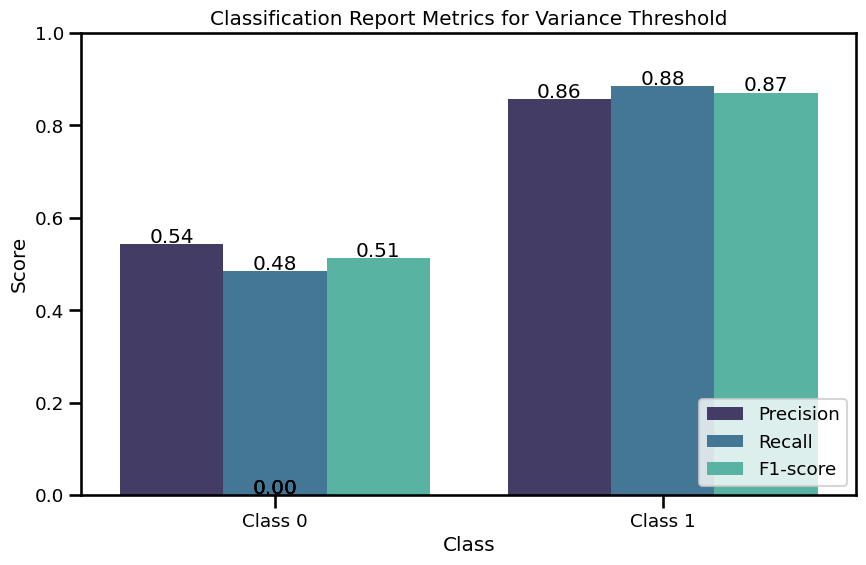

In [12]:
from loan_data_utils import plot_classification_report_metrics, plot_selected_features
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestClassifier

# Step 1: Remove the target column from the training and test DataFrames for feature selection
X_train_features_only = X_train_processed_df.drop(columns=['target'])
X_test_features_only = X_test_processed_df.drop(columns=['target'])

pipeline_var_thresh = Pipeline(steps=[
    ('variance_threshold', VarianceThreshold(threshold=0.01)),  # Variance threshold for feature selection
    ('classifier', RandomForestClassifier(random_state=42))  # Random Forest Classifier
])

# Step 2: Fit the variance threshold on X_train_features_only (preprocessed data without target)
pipeline_var_thresh.fit(X_train_features_only, y_train_resampled)

# Step 3: Predict on the test data and generate the classification report
y_pred_var_thresh = pipeline_var_thresh.predict(X_test_features_only)
classification_report_var_thresh = classification_report(y_test, y_pred_var_thresh, output_dict=True)
print("Classification Report (Variance Threshold):")
print(classification_report(y_test, y_pred_var_thresh, output_dict=False))

# Step 4: Extract the selected feature names based on variance threshold
var_thresh = pipeline_var_thresh.named_steps['variance_threshold']
selected_var_features = var_thresh.get_support()

# Get the feature names corresponding to the selected features
selected_feature_names_var_thresh = [X_train_features_only.columns[i] for i in range(len(X_train_features_only.columns)) if selected_var_features[i]]

# Print selected feature names for verification
print("Selected features using Variance Threshold:")
print(selected_feature_names_var_thresh)

# Step 5: Save the classification report and selected features
# Initialize dictionaries for the first run
results = {}
selected_features = {}

# Add the classification report for variance threshold
results['Variance Threshold'] = classification_report_var_thresh

# Add the selected features (no scores for Variance Threshold)
selected_features['Variance Threshold'] = selected_feature_names_var_thresh

# Save classification reports and selected features to separate JSON files
with open('classification_reports.json', 'w') as f:
    json.dump(results, f, indent=4)

with open('selected_features.json', 'w') as f:
    json.dump(selected_features, f, indent=4)

print("Variance threshold feature selection completed and saved.")

# Plot the classification report metrics
plot_classification_report_metrics(results['Variance Threshold'], 'Variance Threshold')


## Correlation-Based Feature Selection
The idea here is to calculate the correlation matrix and identify pairs of features that are highly correlated (e.g., with a correlation greater than 0.9). We can then remove one of the features in each correlated pair to reduce multicollinearity and redundancy.

Classification Report (Correlation-Based Feature Selection):
              precision    recall  f1-score   support

           0       0.56      0.48      0.51      1326
           1       0.86      0.89      0.87      4667

    accuracy                           0.80      5993
   macro avg       0.71      0.68      0.69      5993
weighted avg       0.79      0.80      0.79      5993

Correlation-based feature selection completed and saved.
Selected features using Correlation-Based Feature Selection:
['age', 'limit_bal', 'bill_amt_4_april', 'pay_amt_4_april', 'pay_amt_5_may', 'pay_amt_6_june', 'pay_amt_7_july', 'pay_amt_8_august', 'pay_amt_9_september', 'severe_delay_count', 'cumulative_delay', 'severe_delay_payment_ratio', 'avg_payment_severe_delays', 'total_payments', 'payment_std', 'debt_to_limit_ratio', 'sex_Female', 'marriage_Married', 'marriage_Unknown/Others', 'education_marriage_Graduate School_Married', 'education_marriage_Graduate School_Single', 'education_marriage_Graduate 

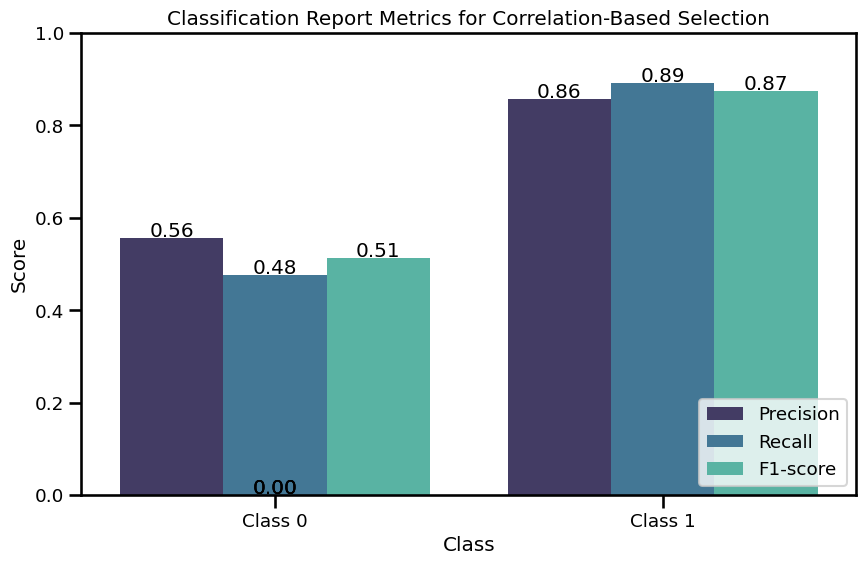

In [13]:
import numpy as np
import pandas as pd
import json
from loan_data_utils import plot_classification_report_metrics
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Step 1: Compute the correlation matrix for the features
correlation_matrix = X_train_features_only.corr()

# Step 2: Identify pairs of features with a high correlation (e.g., above 0.9)
correlation_threshold = 0.9
high_correlation_pairs = np.where(np.abs(correlation_matrix) > correlation_threshold)

# Step 3: Extract the list of features to drop (only consider the upper triangle of the matrix)
features_to_drop = set()
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > correlation_threshold:
            features_to_drop.add(correlation_matrix.columns[i])

# Step 4: Drop the highly correlated features from the dataset
X_train_corr_filtered = X_train_features_only.drop(columns=features_to_drop)
X_test_corr_filtered = X_test_features_only.drop(columns=features_to_drop)

# Step 5: Fit a classifier to the filtered features
pipeline_corr = Pipeline(steps=[
    ('classifier', RandomForestClassifier(random_state=42))
])

# Train the pipeline with the correlation-filtered features
pipeline_corr.fit(X_train_corr_filtered, y_train_resampled)

# Step 6: Predict on the test data and generate the classification report
y_pred_corr = pipeline_corr.predict(X_test_corr_filtered)
classification_report_corr = classification_report(y_test, y_pred_corr, output_dict=True)
print("Classification Report (Correlation-Based Feature Selection):")
print(classification_report(y_test, y_pred_corr, output_dict=False))

# Step 7: Append results to the existing JSON files
# Load existing classification reports and selected features
with open('classification_reports.json', 'r') as f:
    classification_reports = json.load(f)

with open('selected_features.json', 'r') as f:
    selected_features = json.load(f)

# Add the classification report and selected features for correlation-based selection
classification_reports['Correlation-Based Selection'] = classification_report_corr
selected_features['Correlation-Based Selection'] = list(X_train_corr_filtered.columns)

# Save updated classification reports and selected features to JSON
with open('classification_reports.json', 'w') as f:
    json.dump(classification_reports, f, indent=4)

with open('selected_features.json', 'w') as f:
    json.dump(selected_features, f, indent=4)

print("Correlation-based feature selection completed and saved.")

# Print selected feature names for verification
print("Selected features using Correlation-Based Feature Selection:")
print(selected_features['Correlation-Based Selection'])

# Plot the classification report metrics
plot_classification_report_metrics(classification_report_corr, 'Correlation-Based Selection')

## ANOVA

Classification Report (ANOVA Feature Selection):
              precision    recall  f1-score   support

           0       0.55      0.49      0.52      1326
           1       0.86      0.89      0.87      4667

    accuracy                           0.80      5993
   macro avg       0.71      0.69      0.70      5993
weighted avg       0.79      0.80      0.79      5993

ANOVA feature selection completed and saved.
Selected features using ANOVA Feature Selection:
{'age': 0.11113690131882682, 'limit_bal': 1786.8427763810619, 'bill_amt_4_april': 7.184640983786415, 'bill_amt_5_may': 17.724443226210088, 'bill_amt_6_june': 28.004472033240372, 'bill_amt_7_july': 38.2154941008755, 'bill_amt_8_august': 47.095245757140404, 'bill_amt_9_september': 73.17625678493573, 'pay_amt_4_april': 880.1518332623855, 'pay_amt_5_may': 867.7962805007356, 'pay_amt_6_june': 903.2625951164713, 'pay_amt_7_july': 1135.2639291358491, 'pay_amt_8_august': 1381.083282264498, 'pay_amt_9_september': 1430.272401381895, '

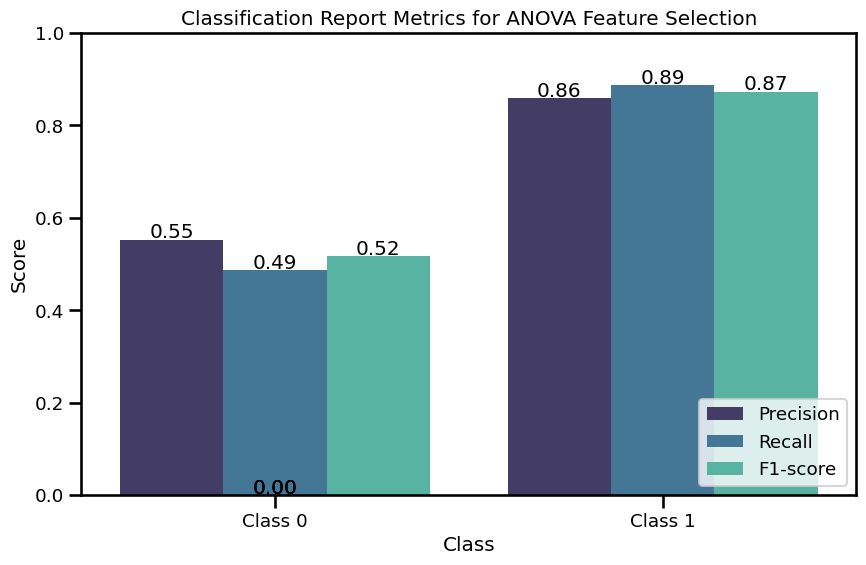

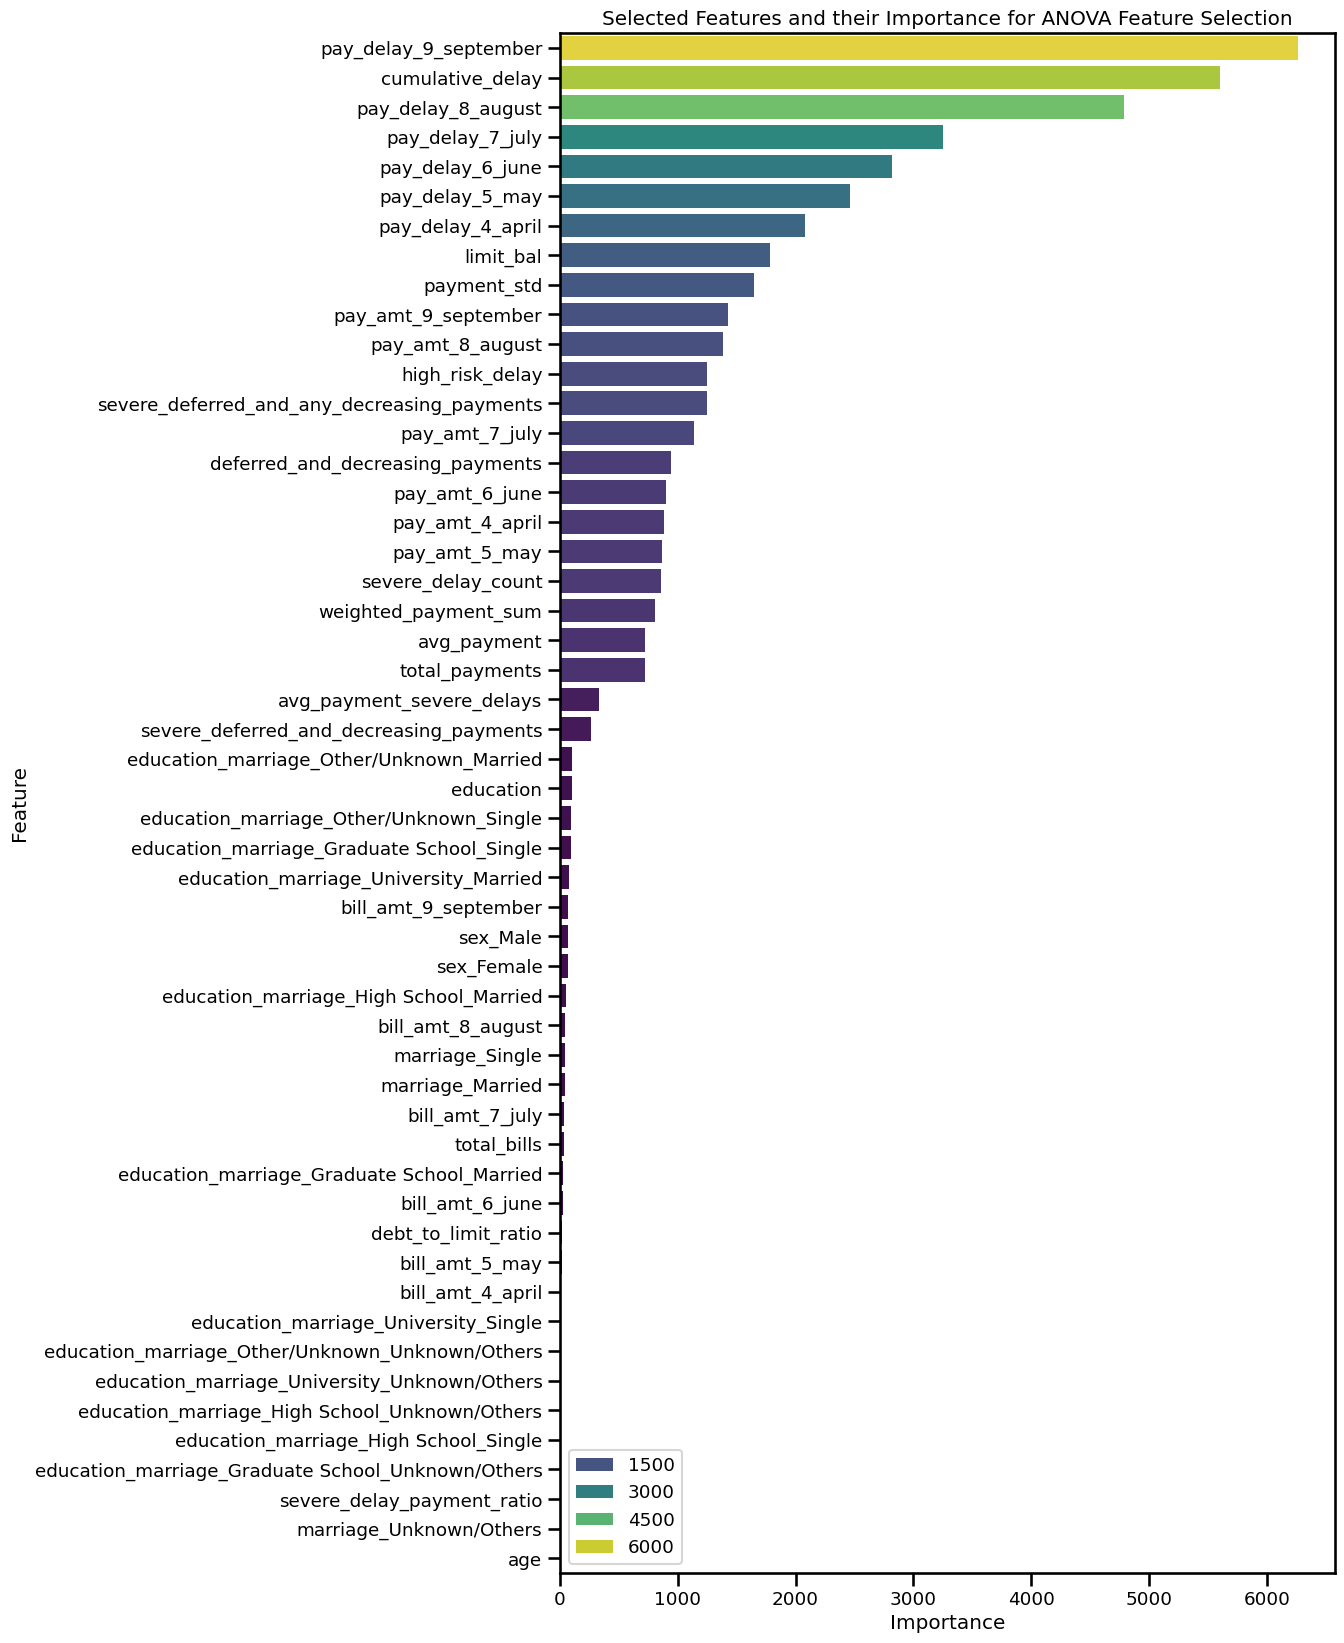

In [14]:
from sklearn.feature_selection import SelectKBest, f_classif
from loan_data_utils import plot_classification_report_metrics, plot_selected_features

# Step 1: Perform ANOVA feature selection using SelectKBest with f_classif (ANOVA F-value)
anova_selector = SelectKBest(score_func=f_classif, k='all')  # 'all' to get scores for all features

# Step 2: Fit the ANOVA selector on the training data (without the target column)
anova_selector.fit(X_train_features_only, y_train_resampled)

# Step 3: Apply the ANOVA feature selection to the training and test sets
X_train_anova_filtered = anova_selector.transform(X_train_features_only)
X_test_anova_filtered = anova_selector.transform(X_test_features_only)

# Step 4: Train a classifier on the ANOVA-filtered features
pipeline_anova = Pipeline(steps=[
    ('classifier', RandomForestClassifier(random_state=42))
])

pipeline_anova.fit(X_train_anova_filtered, y_train_resampled)

# Step 5: Predict on the test data and generate the classification report
y_pred_anova = pipeline_anova.predict(X_test_anova_filtered)
classification_report_anova = classification_report(y_test, y_pred_anova, output_dict=True)
print("Classification Report (ANOVA Feature Selection):")
print(classification_report(y_test, y_pred_anova, output_dict=False))

# Step 6: Extract the selected features based on ANOVA F-value
anova_scores = anova_selector.scores_
selected_anova_features = [X_train_features_only.columns[i] for i in range(len(X_train_features_only.columns)) if anova_scores[i] > 0]
selected_anova_scores = {X_train_features_only.columns[i]: anova_scores[i] for i in range(len(X_train_features_only.columns)) if anova_scores[i] > 0}

# Step 7: Append the ANOVA results to the existing JSON files
# Load existing classification reports and selected features
with open('classification_reports.json', 'r') as f:
    classification_reports = json.load(f)

with open('selected_features.json', 'r') as f:
    selected_features = json.load(f)

# Add the classification report and selected features for ANOVA
classification_reports['ANOVA Feature Selection'] = classification_report_anova
selected_features['ANOVA Feature Selection'] = selected_anova_scores

# Save updated classification reports and selected features to JSON
with open('classification_reports.json', 'w') as f:
    json.dump(classification_reports, f, indent=4)

with open('selected_features.json', 'w') as f:
    json.dump(selected_features, f, indent=4)

print("ANOVA feature selection completed and saved.")

# Print selected feature names and their scores for verification
print("Selected features using ANOVA Feature Selection:")
print(selected_anova_scores)

# Step 8: Plot the classification report metrics and sorted selected features by importance
plot_classification_report_metrics(classification_report_anova, 'ANOVA Feature Selection')

# Sort features by importance (ANOVA F-scores)
sorted_anova_features = dict(sorted(selected_anova_scores.items(), key=lambda item: item[1], reverse=True))
plot_selected_features(sorted_anova_features, 'ANOVA Feature Selection', figsize=(10,20))


## Mutual Information

Classification Report (Mutual Information Feature Selection):
              precision    recall  f1-score   support

           0       0.55      0.49      0.52      1326
           1       0.86      0.89      0.87      4667

    accuracy                           0.80      5993
   macro avg       0.71      0.69      0.70      5993
weighted avg       0.79      0.80      0.79      5993

Mutual Information feature selection completed and saved.
Selected features using Mutual Information Feature Selection:
{'age': 0.3158383027766971, 'limit_bal': 0.28943700879870704, 'bill_amt_4_april': 0.017287925266006976, 'bill_amt_5_may': 0.018416507385046632, 'bill_amt_6_june': 0.014186942508564115, 'bill_amt_7_july': 0.01384202308337823, 'bill_amt_8_august': 0.010060626454766686, 'bill_amt_9_september': 0.008389918140213393, 'pay_amt_4_april': 0.0824897847895294, 'pay_amt_5_may': 0.07675649581944932, 'pay_amt_6_june': 0.07353391781011931, 'pay_amt_7_july': 0.07640001498585969, 'pay_amt_8_august': 0.

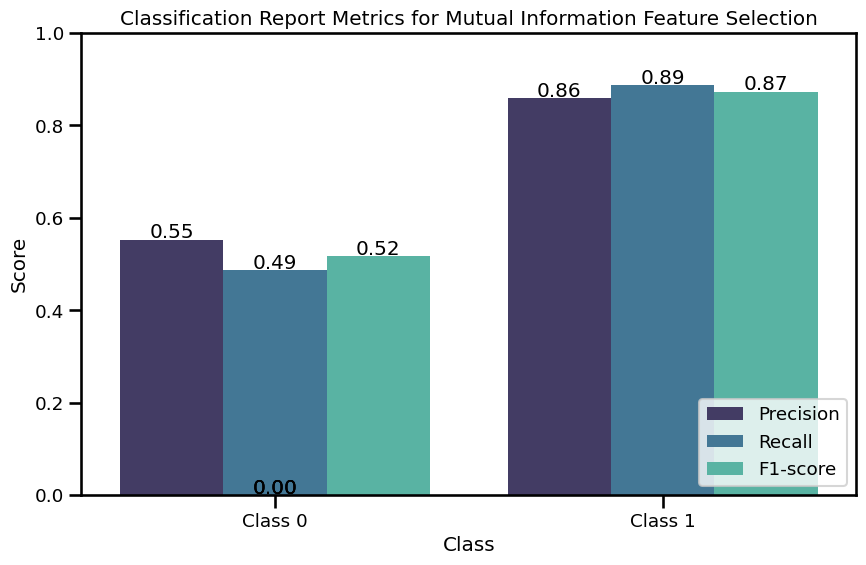

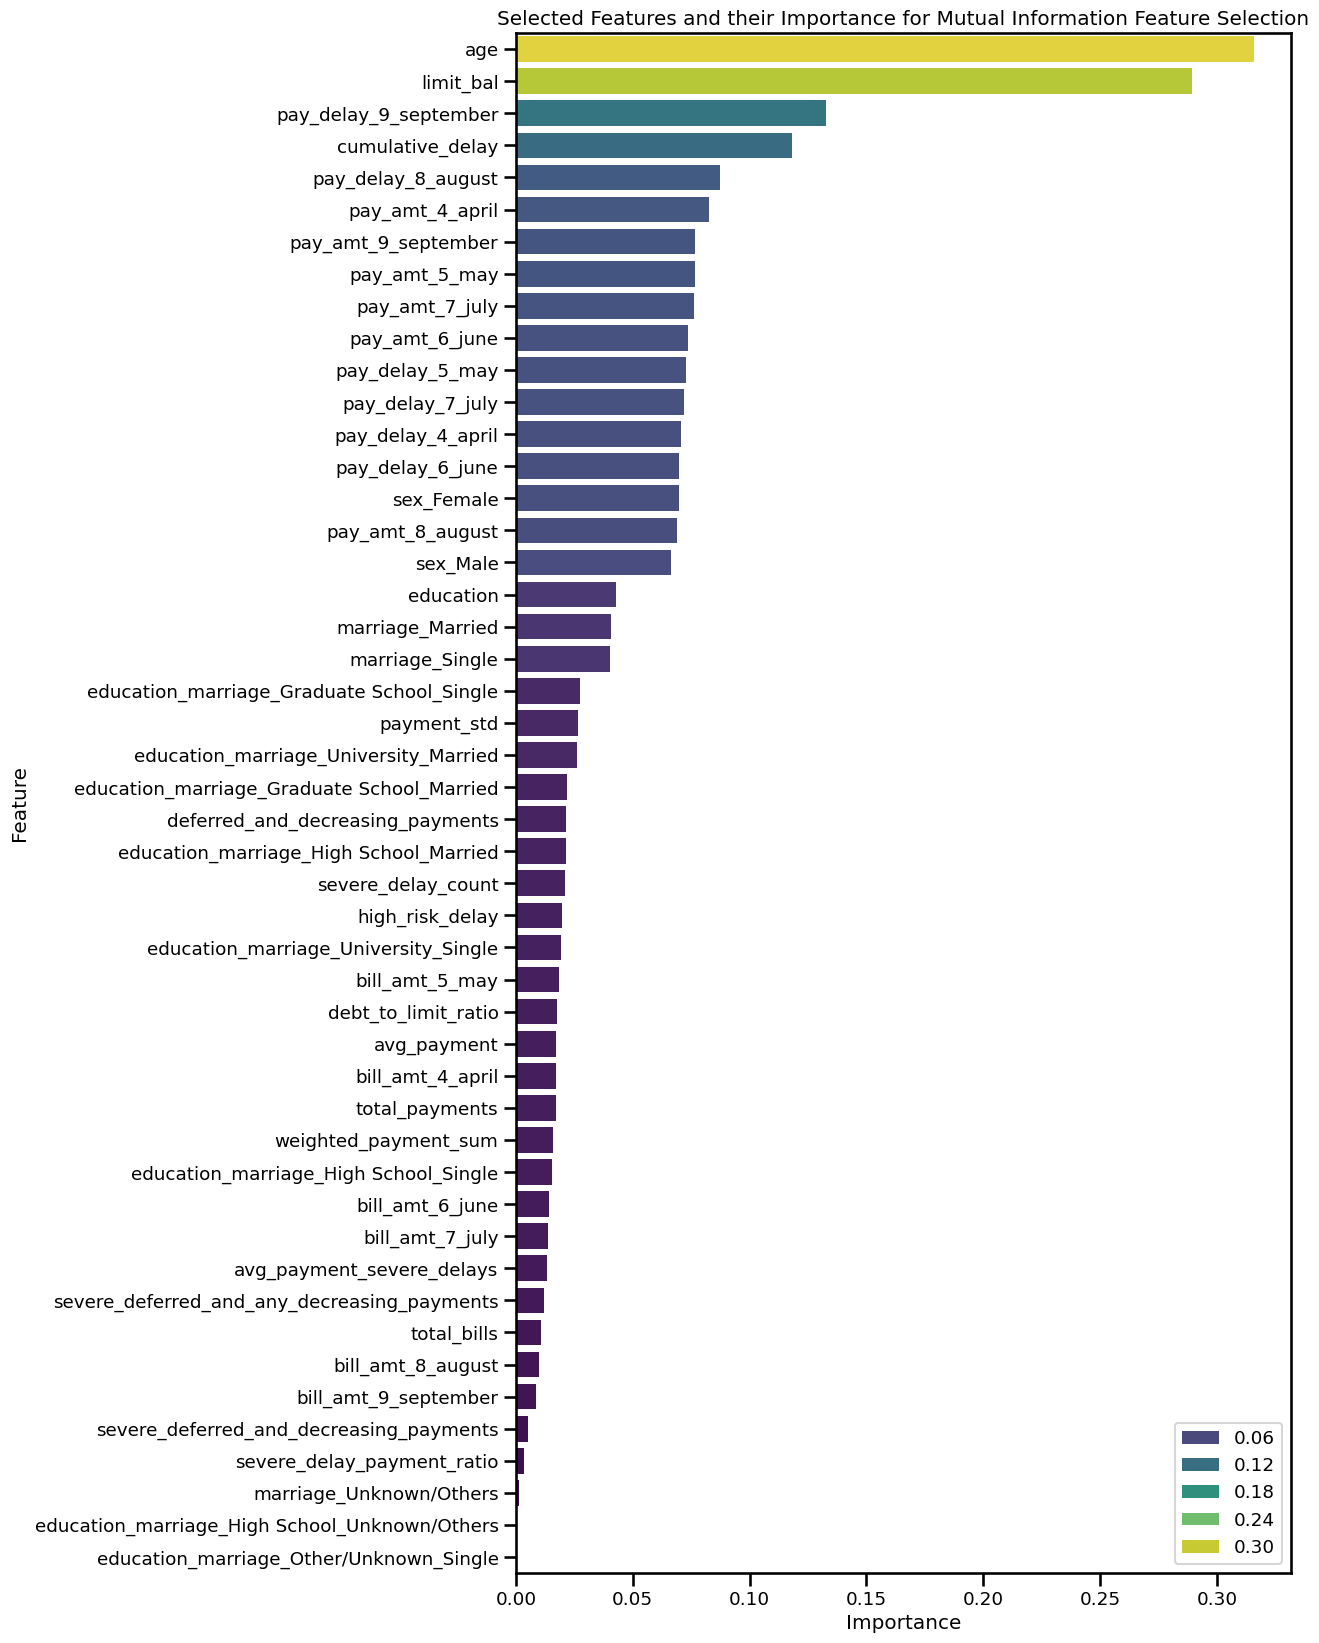

In [15]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif
import json
from loan_data_utils import plot_classification_report_metrics, plot_selected_features

# Step 1: Perform Mutual Information feature selection using SelectKBest with mutual_info_classif
mi_selector = SelectKBest(score_func=mutual_info_classif, k='all')  # 'all' to get scores for all features

# Step 2: Fit the Mutual Information selector on the training data (without the target column)
mi_selector.fit(X_train_features_only, y_train_resampled)

# Step 3: Apply the Mutual Information feature selection to the training and test sets
X_train_mi_filtered = mi_selector.transform(X_train_features_only)
X_test_mi_filtered = mi_selector.transform(X_test_features_only)

# Step 4: Train a classifier on the Mutual Information-filtered features
pipeline_mi = Pipeline(steps=[
    ('classifier', RandomForestClassifier(random_state=42))
])

pipeline_mi.fit(X_train_mi_filtered, y_train_resampled)

# Step 5: Predict on the test data and generate the classification report
y_pred_mi = pipeline_mi.predict(X_test_mi_filtered)
classification_report_mi = classification_report(y_test, y_pred_mi, output_dict=True)
print("Classification Report (Mutual Information Feature Selection):")
print(classification_report(y_test, y_pred_mi, output_dict=False))

# Step 6: Extract the selected features based on Mutual Information scores
mi_scores = mi_selector.scores_
selected_mi_features = [X_train_features_only.columns[i] for i in range(len(X_train_features_only.columns)) if mi_scores[i] > 0]
selected_mi_scores = {X_train_features_only.columns[i]: mi_scores[i] for i in range(len(X_train_features_only.columns)) if mi_scores[i] > 0}

# Step 7: Append the Mutual Information results to the existing JSON files
# Load existing classification reports and selected features
with open('classification_reports.json', 'r') as f:
    classification_reports = json.load(f)

with open('selected_features.json', 'r') as f:
    selected_features = json.load(f)

# Add the classification report and selected features for Mutual Information
classification_reports['Mutual Information Feature Selection'] = classification_report_mi
selected_features['Mutual Information Feature Selection'] = selected_mi_scores

# Save updated classification reports and selected features to JSON
with open('classification_reports.json', 'w') as f:
    json.dump(classification_reports, f, indent=4)

with open('selected_features.json', 'w') as f:
    json.dump(selected_features, f, indent=4)

print("Mutual Information feature selection completed and saved.")

# Print selected feature names and their scores for verification
print("Selected features using Mutual Information Feature Selection:")
print(selected_mi_scores)

# Step 8: Plot the classification report metrics and sorted selected features by importance
plot_classification_report_metrics(classification_report_mi, 'Mutual Information Feature Selection')

# Sort features by importance (Mutual Information scores)
sorted_mi_features = dict(sorted(selected_mi_scores.items(), key=lambda item: item[1], reverse=True))
plot_selected_features(sorted_mi_features, 'Mutual Information Feature Selection',figsize=(10,20))


#### Loan Data Utils

In [16]:
script_content=r'''
# loan_data_utils.py

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import logging
from sklearn.metrics import classification_report
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin

import json

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

target = 'default_payment_next_month'
# Define primary, bill, and pay columns
primary_columns = ['limit_bal', 'sex', 'education', 'marriage', 'age']
bill_columns = ['bill_amt_4_april', 'bill_amt_5_may', 'bill_amt_6_june', 'bill_amt_7_july', 'bill_amt_8_august', 'bill_amt_9_september']
pay_columns = ['pay_amt_4_april', 'pay_amt_5_may', 'pay_amt_6_june', 'pay_amt_7_july', 'pay_amt_8_august', 'pay_amt_9_september']
ordinal_columns = ['education', 'pay_delay_9_september', 'pay_delay_8_august', 'pay_delay_7_july', 'pay_delay_6_june', 'pay_delay_5_may', 'pay_delay_4_april']

def load_data_from_url(url):
    try:
        df = pd.read_excel(url, header=1)
        logging.info("Data loaded successfully from URL.")
    except Exception as e:
        logging.error(f"Error loading data from URL: {e}")
        return None
    return df

def split_features_target(df, target):
    try:
        X = df.drop(columns=[target])
        y = df[target]
        logging.info("Features and target split successfully.")
    except Exception as e:
        logging.error(f"Error splitting features and target: {e}")
        return None, None
    return X, y


def clean_column_names(df):
    try:
        df.columns = [col.lower().replace(' ', '_') for col in df.columns]
        logging.info("Column names cleaned successfully.")
    except Exception as e:
        logging.error(f"Error cleaning column names: {e}")
    return df

def remove_id_column(df):
    if 'id' in df.columns:
        df = df.drop(columns=['id'])
        logging.info("ID column removed.")
    return df

# ---------  Sex Column Processing  --------- #
# ---- SEX: Gender (1 = male, 2 = female) ----#

# results in cat.categories = ['Female', 'Male'][0,1]
def process_sex_column(df):
    try:
        if 'sex' in df.columns:
            df['sex'] = df['sex'].replace({1: 'Male', 2: 'Female'})
            df['sex'] = df['sex'].astype('category')
            logging.info("Sex column processed and converted to categorical successfully.")
        else:
            logging.warning("Sex column not found in DataFrame.")
    except Exception as e:
        logging.error(f"Error processing sex column: {e}")
    return df

# results in cat.categories = ['Female', 'Male'][2,1] (alphabetically ordered)
def process_sex_column_cat_codes_one_two(df):
    try:
        if 'sex' in df.columns:
            # Convert numeric values to categorical, maintaining original codes
            df['sex'] = df['sex'].astype('category')  # First, ensure the column is categorical

            # Define the categories explicitly and map original values (1: Male, 2: Female)
            df['sex'].cat.set_categories([1, 2], rename=True, inplace=True)  # Set categories as 1, 2
            df['sex'] = df['sex'].replace({1: 'Male', 2: 'Female'})  # Replace numeric values with labels

            logging.info("Sex column processed and converted to categorical successfully.")
        else:
            logging.warning("Sex column not found in DataFrame.")
    except Exception as e:
        logging.error(f"Error processing sex column: {e}")
    return df

# ---------  Marriage Column Processing  --------- #

# ---- MARRIAGE: Marital status (1 = married, 2 = single, 3 = other) ----#

def process_marriage_column(df):
    try:
        if 'marriage' in df.columns:
            df['marriage'] = df['marriage'].replace({0: 'Unknown/Others', 3: 'Unknown/Others'})
            df['marriage'] = df['marriage'].replace({1: 'Married', 2: 'Single'})
            df['marriage'] = pd.Categorical(df['marriage'], categories=['Married', 'Single', 'Unknown/Others'], ordered=False)
            logging.info("Marriage column processed and converted to categorical successfully.")
        else:
            logging.warning("Marriage column not found in DataFrame.")
    except Exception as e:
        logging.error(f"Error processing marriage column: {e}")
    return df

# ---------  Target Column Processing  --------- #

def process_default_payment_column(df):
    try:
        if 'default_payment_next_month' in df.columns:
            # Convert 0 and 1 to categorical values
            df['default_payment_next_month'] = df['default_payment_next_month'].astype('category')
            logging.info("Default payment column processed and converted to categorical successfully.")
        else:
            logging.warning("Default payment column not found in DataFrame.")
    except Exception as e:
        logging.error(f"Error processing default payment column: {e}")
    return df

# convert category labels for EDA
def process_default_payment_column(df):
    try:
        if 'default_payment_next_month' in df.columns:
            # Label the categories
            df['default_payment_next_month'] = df['default_payment_next_month'].replace({0: 'No Default', 1: 'Default'})
            df['default_payment_next_month'] = df['default_payment_next_month'].astype('category')
            logging.info("Default payment column labeled and converted to categorical successfully.")
        else:
            logging.warning("Default payment column not found in DataFrame.")
    except Exception as e:
        logging.error(f"Error processing default payment column: {e}")
    return df

# Convert labels to numeric for modeling
def convert_default_payment_to_numeric(df):
    try:
        if 'default_payment_next_month' in df.columns:
            df['default_payment_next_month'] = df['default_payment_next_month'].replace({'No Default': 0, 'Default': 1}).astype(int)
            logging.info("Default payment column converted back to numeric for modeling.")
        else:
            logging.warning("Default payment column not found in DataFrame.")
    except Exception as e:
        logging.error(f"Error converting default payment column to numeric: {e}")
    return df

# ---------  Pay Delay Column Processing  --------- #

def rename_pay_columns(df):
    try:
        # Only rename if the original columns exist
        if all(col in df.columns for col in ['pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6']):
            pay_columns_new_names = {
                'pay_0': 'pay_delay_9_september',
                'pay_2': 'pay_delay_8_august',
                'pay_3': 'pay_delay_7_july',
                'pay_4': 'pay_delay_6_june',
                'pay_5': 'pay_delay_5_may',
                'pay_6': 'pay_delay_4_april'
            }
            df = df.rename(columns=pay_columns_new_names)
            logging.info("Pay delay columns renamed successfully.")
        else:
            logging.warning("Some or all of the expected pay columns are missing. Renaming skipped.")
    except Exception as e:
        logging.error(f"Error renaming pay delay columns: {e}")
    return df

def rename_bill_and_payment_columns(df):
    try:
        # Correct renaming of bill_amt and pay_amt columns
        bill_amt_new_names = {
            'bill_amt1': 'bill_amt_9_september',
            'bill_amt2': 'bill_amt_8_august',
            'bill_amt3': 'bill_amt_7_july',
            'bill_amt4': 'bill_amt_6_june',
            'bill_amt5': 'bill_amt_5_may',
            'bill_amt6': 'bill_amt_4_april'
        }

        pay_amt_new_names = {
            'pay_amt1': 'pay_amt_9_september',
            'pay_amt2': 'pay_amt_8_august',
            'pay_amt3': 'pay_amt_7_july',
            'pay_amt4': 'pay_amt_6_june',
            'pay_amt5': 'pay_amt_5_may',
            'pay_amt6': 'pay_amt_4_april'
        }

        df = df.rename(columns={**bill_amt_new_names, **pay_amt_new_names})
        logging.info("Bill and payment columns renamed successfully.")
    except Exception as e:
        logging.error(f"Error renaming bill and payment columns: {e}")
    return df


def label_pay_columns(df, pay_columns):
    try:
        # Only label the pay_delay_* columns, not pay_amt_*
        pay_labels = {
            -2: "No consumption",
            -1: "Paid in full",
            0: "Revolving credit",
            1: "1 month delay",
            2: "2 months delay",
            3: "3 months delay",
            4: "4 months delay",
            5: "5 months delay",
            6: "6 months delay",
            7: "7 months delay",
            8: "8 months delay",
            9: "9+ months delay"
        }

        for col in pay_columns:
            # Ensure we're only mapping the delay columns and not payment amount columns
            if 'pay_delay' in col and col in df.columns:
                df[col] = df[col].map(pay_labels)
                logging.info(f"Column {col} labeled successfully.")
            else:
                logging.error(f"Column {col} not found in DataFrame.")

    except Exception as e:
        logging.error(f"Error labeling pay columns: {e}")
    return df

def convert_pay_columns_to_ordinal(df, pay_columns):
    try:
        pay_order = [
            "No consumption",  # -2
            "Paid in full",    # -1
            "Revolving credit", # 0
            "1 month delay",   # 1
            "2 months delay",  # 2
            "3 months delay",  # 3
            "4 months delay",  # 4
            "5 months delay",  # 5
            "6 months delay",  # 6
            "7 months delay",  # 7
            "8 months delay",  # 8
            "9+ months delay"  # 9
        ]

        for col in pay_columns:
            # Ensure only delay columns are converted to categorical
            if 'pay_delay' in col and col in df.columns:
                df[col] = pd.Categorical(df[col], categories=pay_order, ordered=True)
                logging.info(f"Column {col} converted to ordinal successfully.")
            else:
                logging.error(f"Column {col} not found in DataFrame.")

    except Exception as e:
        logging.error(f"Error converting pay columns to ordinal categories: {e}")
    return df


def convert_ordinal_to_category(df, ordinal_columns):
    try:
        for col in ordinal_columns:
            if col in df.columns:
                df[col] = df[col].astype('category')
                logging.info(f"Column {col} converted to category successfully.")
            else:
                logging.error(f"Column {col} not found in DataFrame.")
    except Exception as e:
        logging.error(f"Error converting ordinal columns to category: {e}")
    return df

# ---------  Education Column Processing  --------- #

def convert_education_to_ordinal(df):
    try:
        # Explicitly map all values to handle known categories
        education_mapping = {
            1: 'Graduate School',
            2: 'University',
            3: 'High School',
            4: 'Other/Unknown',
            5: 'Other/Unknown',
            6: 'Other/Unknown',
            0: 'Other/Unknown'  # Handle the 0 value as well
        }

        df['education'] = df['education'].replace(education_mapping)

        # Define the order of education categories
        education_order = [
            "Other/Unknown",    # Grouped 0, 4, 5, 6 together
            "High School",      # 3
            "University",       # 2
            "Graduate School"   # 1
        ]

        if 'education' in df.columns:
            # Convert the education column to a categorical type with the specified order
            df['education'] = pd.Categorical(df['education'], categories=education_order, ordered=True)
            logging.info("Education column converted to ordinal categories successfully.")
        else:
            logging.error("Education column not found in DataFrame.")
    except Exception as e:
        logging.error(f"Error converting education column to ordinal categories: {e}")
    return df


#-------- Utility and validation functions first ----------#

def check_column_integrity(df, expected_columns):
    missing_columns = [col for col in expected_columns if col not in df.columns]
    if missing_columns:
        logging.error(f"Missing columns: {missing_columns}")
    else:
        logging.info("All expected columns are present.")

def validate_data_types(df, ordinal_columns):
    for col in ordinal_columns:
        if col in df.columns:
            if not pd.api.types.is_categorical_dtype(df[col]):
                logging.warning(f"Column {col} is not correctly set as categorical.")
            else:
                logging.info(f"Column {col} is correctly set as categorical with the following categories: {df[col].cat.categories}")
        else:
            logging.error(f"Column {col} not found in DataFrame.")
    logging.info("Data type validation complete.")

def reorder_columns(df):
    try:
        # Define the order of the pay_delay columns in chronological order
        pay_delay_order = [
            'pay_delay_4_april',
            'pay_delay_5_may',
            'pay_delay_6_june',
            'pay_delay_7_july',
            'pay_delay_8_august',
            'pay_delay_9_september'
        ]

        # Combine primary, bill, pay, and pay_delay columns with other columns
        other_columns = [col for col in df.columns if col not in primary_columns + bill_columns + pay_columns + pay_delay_order]
        df = df[primary_columns + bill_columns + pay_columns + pay_delay_order + other_columns]
        logging.info("Columns reordered successfully.")
    except Exception as e:
        logging.error(f"Error reordering columns: {e}")
    return df


#--------  Load and Preprocess Data  --------- #

def load_and_preprocess_data(url, categorical_columns, target):
    df = load_data_from_url(url)
    if df is not None:
        try:
            # Include the target column from the start
            df = clean_column_names(df)
            df = remove_id_column(df)
            df = rename_pay_columns(df)
            df = rename_bill_and_payment_columns(df)
            df = label_pay_columns(df, [col for col in df.columns if 'pay_delay' in col])
            df = convert_pay_columns_to_ordinal(df, [col for col in df.columns if 'pay_delay' in col])
            df = reorder_columns(df)
            df = convert_education_to_ordinal(df)
            df = process_sex_column(df)
            # df = process_sex_column_cat_codes_one_two(df)
            df = process_marriage_column(df)
            df = process_default_payment_column(df)
            df = convert_ordinal_to_category(df, ordinal_columns)

            # Run validation checks
            check_column_integrity(df, primary_columns + bill_columns + pay_columns + ordinal_columns)
            validate_data_types(df, ordinal_columns)

            # Drop duplicates consistently across both features and target
            df = df.drop_duplicates()

            logging.info("Data loaded and preprocessed successfully.")
            return df
        except Exception as e:
            logging.error(f"Error in data preprocessing: {e}")
            return None
    return None

#--------  Load Preprocess Split Data  --------- #

def load_preprocess_split_data(url, categorical_columns, target):
    df = load_data_from_url(url)
    if df is not None:
        try:
            df = clean_column_names(df)
            df = remove_id_column(df)
            df = rename_pay_columns(df)
            df = rename_bill_and_payment_columns(df)
            df = label_pay_columns(df, [col for col in df.columns if 'pay_delay' in col])
            df = convert_pay_columns_to_ordinal(df, [col for col in df.columns if 'pay_delay' in col])
            df = reorder_columns(df)
            df = convert_education_to_ordinal(df)
            df = process_sex_column(df)  # Process the sex column separately
            df = process_marriage_column(df)  # Process the marriage column separately
            df = convert_ordinal_to_category(df, ordinal_columns)

            # Run validation checks
            check_column_integrity(df, primary_columns + bill_columns + pay_columns + ordinal_columns)
            validate_data_types(df, ordinal_columns)

            X, y = split_features_target(df, target)
            logging.info("Data loaded and preprocessed successfully.")
            return X, y
        except Exception as e:
            logging.error(f"Error in data preprocessing: {e}")
            return None, None
    return None, None


def check_categorical_order(df, columns):
    for col in columns:
        if pd.api.types.is_categorical_dtype(df[col]):
            print(f"Column: {col}")
            print(f"Categories: {df[col].cat.categories}")
            print(f"Ordered: {df[col].cat.ordered}\n")
        else:
            print(f"Column: {col} is not categorical.\n")

#--------  Plot Categorical Data Functions  --------- #

categorical_columns = [
    'default_payment_next_month', 'sex', 'education', 'marriage'
]

ordinal_columns = [
    'pay_delay_4_april', 'pay_delay_5_may', 'pay_delay_6_june',
    'pay_delay_7_july', 'pay_delay_8_august', 'pay_delay_9_september'
]

def plot_categorical_distributions(df, categorical_columns):
    """Function to plot categorical distributions."""
    plt.figure(figsize=(16, 14))
    sns.set_context('talk')
    for i, column in enumerate(categorical_columns, 1):
        plt.subplot(2, 2, i)
        sns.countplot(data=df, x=column, hue=column, palette='Set3', legend=False)
        plt.title(f'Distribution of {column}')
        plt.xlabel(column)
        plt.ylabel('Count')

        # Add percentage annotations
        total = len(df)
        for p in plt.gca().patches:
            percentage = 100 * p.get_height() / total
            plt.gca().text(p.get_x() + p.get_width() / 2, p.get_height(),
                           f'{percentage:.1f}%', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()


def plot_ordinal_distributions(df, ordinal_columns):
    """Function to plot ordinal distributions using barplot with hue."""
    plt.figure(figsize=(16, 25))
    sns.set_context('talk', font_scale=0.8)
    for i, column in enumerate(ordinal_columns, 1):
        plt.subplot(3, 2, i)

        # Get the counts for each category
        category_counts = df[column].value_counts().sort_index()

        sns.barplot(x=category_counts.index, y=category_counts.values, hue=category_counts.index, palette='Set3')

        plt.title(f'Distribution of {column}')
        plt.xlabel(column)
        plt.ylabel('Count')

        # Rotate x-tick labels for better legibility
        plt.xticks(rotation=45, ha='right')

        # Add percentage annotations
        total = len(df)
        for p in plt.gca().patches:
            percentage = 100 * p.get_height() / total
            plt.gca().text(p.get_x() + p.get_width() / 2, p.get_height(),
                           f'{percentage:.1f}%', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()


# --------- Custom Transformer for Threshold Classifier --------- #

class ThresholdClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, base_classifier=None, threshold=0.5):
        # Default to LogisticRegression if no classifier is provided
        self.base_classifier = base_classifier if base_classifier is not None else LogisticRegression(max_iter=1000)
        self.threshold = threshold

    def fit(self, X, y):
        # Fit the base classifier on the training data
        self.base_classifier.fit(X, y)
        return self

    def predict(self, X):
        # Get the predicted probabilities for class 1 (positive class)
        probas = self.base_classifier.predict_proba(X)[:, 1]
        # Apply the threshold to make class predictions
        return (probas >= self.threshold).astype(int)

    def predict_proba(self, X):
        # Return the predicted probabilities from the base classifier
        return self.base_classifier.predict_proba(X)


#--------  Classification Report Functions  --------- #

# Function to save the classification reports to a JSON file
def save_classification_reports(reports, filename='classification_reports.json'):
    with open(filename, 'w') as json_file:
        json.dump(reports, json_file, indent=4)  # Use indent for pretty-printing
    print(f"Classification reports saved as {filename}")


# Plotting function with annotations
def plot_classification_report_metrics(report, model_name):
    metrics_df = pd.DataFrame({
        'Class': ['Class 0', 'Class 0', 'Class 0', 'Class 1', 'Class 1', 'Class 1'],
        'Metric': ['Precision', 'Recall', 'F1-score', 'Precision', 'Recall', 'F1-score'],
        'Value': [
            report['0']['precision'],
            report['0']['recall'],
            report['0']['f1-score'],
            report['1']['precision'],
            report['1']['recall'],
            report['1']['f1-score']
        ]
    })

    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x='Class', y='Value', hue='Metric', data=metrics_df, palette='mako')
    plt.title(f'Classification Report Metrics for {model_name}')
    plt.ylabel('Score')
    plt.ylim(0, 1)
    plt.legend(loc='lower right')

    # Annotate the bars with the values
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{height:.2f}',
                    (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='center',
                    xytext=(0, 5),
                    textcoords='offset points')

    plt.show()

#--------  Classification Report Functions for Categories  --------- #

# Function to save classification reports with custom categories
def save_classification_reports_with_categories(reports, filename='classification_reports.json'):
    try:
        # Adjust the keys for the class labels to match your custom categories
        for model, report in reports.items():
            if '0' in report and '1' in report:
                report['No Default'] = report.pop('0')
                report['Default'] = report.pop('1')

        with open(filename, 'w') as json_file:
            json.dump(reports, json_file, indent=4)  # Pretty-printing for clarity
        print(f"Classification reports with categories saved as {filename}")
    except Exception as e:
        print(f"Error saving classification reports: {e}")

# Updated plotting function with category names and annotations
def plot_classification_report_metrics_with_categories(report, model_name):
    metrics_df = pd.DataFrame({
        'Class': ['No Default', 'No Default', 'No Default', 'Default', 'Default', 'Default'],
        'Metric': ['Precision', 'Recall', 'F1-score', 'Precision', 'Recall', 'F1-score'],
        'Value': [
            report['No Default']['precision'],
            report['No Default']['recall'],
            report['No Default']['f1-score'],
            report['Default']['precision'],
            report['Default']['recall'],
            report['Default']['f1-score']
        ]
    })

    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x='Class', y='Value', hue='Metric', data=metrics_df, palette='mako')
    plt.title(f'Classification Report Metrics for {model_name}')
    plt.ylabel('Score')
    plt.ylim(0, 1)
    plt.legend(loc='lower right')

    # Annotate the bars with the values
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{height:.2f}',
                    (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='center',
                    xytext=(0, 5),
                    textcoords='offset points')

    plt.show()

#--------   Plot Selected Features  --------#

def plot_selected_features(selected_features, model_name, figsize=(16,8)):
    features = list(selected_features.keys())
    importances = list(selected_features.values())
    plt.figure(figsize=figsize)
    sns.barplot(x=importances, y=features, hue=importances, palette='viridis')
    plt.title(f'Selected Features and their Importance for {model_name}')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.show()
'''

# Write the script to a file
with open("loan_data_utils.py", "w") as file:
    file.write(script_content)

print("Script successfully written to loan_data_utils.py")
# Reload script to make functions available for use
import importlib
import loan_data_utils
importlib.reload(loan_data_utils)

from loan_data_utils import *


Script successfully written to loan_data_utils.py


#### EDA Utils

In [17]:
script_content=r'''
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#--------   Data Overview   --------#

def data_overview(X):
    # Calculate missing values and their percentage
    missing_values = X.isnull().sum().sum()
    missing_percentage = (missing_values / len(X)) * 100

    # Calculate the number of duplicate rows
    duplicate_rows = X.duplicated().sum()

    # Print missing values, missing percentage, and duplicate information
    print("Missing Values:", missing_values)
    print("Missing Percentage:", missing_percentage)
    print(f"Number of Duplicate Rows: {duplicate_rows}\n")

    # Print basic information
    X.info()

#--------   Plot Class Distribution   --------#

def plot_class_distribution(y_train, target_name):
    sns.set()
    sns.set(style="ticks")
    sns.set_context('notebook')
    plt.figure(figsize=(8, 5))
    sns.countplot(x=y_train, hue=y_train, palette='viridis')
    plt.title(f'Class Distribution in Training Set: {target_name}')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.legend([], [], frameon=False)

    # Calculate the percentage for each class
    total = len(y_train)
    class_counts = y_train.value_counts()
    for i, count in enumerate(class_counts):
        percentage = 100 * count / total
        plt.text(i, count, f'{percentage:.1f}%', ha='center', va='bottom')

    plt.show()

#--------   Plot Univariate Distributions   --------#

def plot_univariate_distributions(X, categorical_columns):
    numeric_columns = X.select_dtypes(include=[np.number]).columns
    sns.set(style="ticks")
    sns.set_context('talk')

    # Plot histograms and KDE plots for numeric features
    for col in numeric_columns:
        plt.figure(figsize=(14, 5))

        # Histogram and KDE plot
        plt.subplot(1, 2, 1)
        sns.histplot(X[col], kde=True, color='forestgreen')
        plt.title(f'Distribution of {col}')
        plt.xlabel(col)

        # Boxplot to detect outliers
        plt.subplot(1, 2, 2)
        sns.boxplot(x=X[col], color='limegreen')
        plt.title(f'Boxplot of {col}')
        plt.xlabel(col)

        plt.tight_layout()
        plt.show()

    # Plot bar plots for other categorical features
    for col in categorical_columns:
        plt.figure(figsize=(8, 5))
        sns.countplot(x=X[col], hue=X[col], palette='viridis')
        plt.title(f'Category Distribution of {col}')
        plt.xlabel(col)
        plt.ylabel('Count')
        plt.show()

def plot_pay_delay_distributions(X, pay_delay_columns, aggregate_threshold=10):
    sns.set(style="ticks")
    sns.set_context('talk')

    for col in pay_delay_columns:
        # Aggregate categories with low counts into a single "Other" category
        value_counts = X[col].value_counts()
        low_count_categories = value_counts[value_counts < aggregate_threshold].index
        X[col] = X[col].apply(lambda x: 'Other' if x in low_count_categories else x)

        plt.figure(figsize=(10, 5))

        # Count plot for pay_delay columns
        sns.countplot(x=X[col], hue=X[col], palette='viridis', order=value_counts.index)
        plt.title(f'Distribution of {col.replace("_", " ").title()} (Aggregated)')
        plt.xlabel(col)
        plt.ylabel('Count')

        # Rotate the x-axis labels for better visibility
        plt.xticks(rotation=45)
        plt.show()

'''

# Write the script to a file
with open("eda_utils.py", "w") as file:
    file.write(script_content)

print("Script successfully written to eda_utils.py")
# Reload script to make functions available for use
import importlib
import eda_utils
importlib.reload(eda_utils)

from eda_utils import *

Script successfully written to eda_utils.py


#### Data Transform Utils

In [18]:
script_content=r'''

# data_transformations_utils.py

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mstats
from sklearn.preprocessing import RobustScaler, PowerTransformer, QuantileTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import json
import logging

# Function to evaluate the baseline model
def evaluate_baseline_model(preprocessor, X_train, X_test, y_train, y_test):
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(max_iter=1000, random_state=42))
    ])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True)
    return report

# Function to apply Winsorization (Capping)
def winsorize_transform(X):
    X_transformed = X.copy()
    for col in X_transformed.columns:
        X_transformed[col] = mstats.winsorize(X_transformed[col], limits=[0.05, 0.05])
    return X_transformed

# Function to apply the Combined Method: IQR + Winsorization + Robust Scaling
def combined_outlier_removal(X):
    # Step 1: Apply IQR method to remove outliers
    def apply_iqr_outlier_removal(df):
        df_cleaned = df.copy()
        for col in df_cleaned.columns:
            Q1 = df_cleaned[col].quantile(0.25)
            Q3 = df_cleaned[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            df_cleaned = df_cleaned[(df_cleaned[col] >= lower_bound) & (df_cleaned[col] <= upper_bound)]
        return df_cleaned

    # Step 2: Apply Winsorization to cap extreme values
    def apply_winsorization(df):
        df_winsorized = df.copy()
        for col in df_winsorized.columns:
            df_winsorized[col] = mstats.winsorize(df_winsorized[col], limits=[0.05, 0.05])
        return df_winsorized

    # Step 3: Apply RobustScaler to normalize the data
    def apply_robust_scaler(df):
        scaler = RobustScaler()
        return pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

    # Apply all the steps in sequence
    X_cleaned = apply_iqr_outlier_removal(X)
    X_winsorized = apply_winsorization(X_cleaned)
    X_scaled = apply_robust_scaler(X_winsorized)

    return X_scaled


# Function to create the preprocessing pipeline
def create_preprocessor(ordinal_columns, categorical_columns, numeric_columns, categories_for_encoder):
    preprocessor = ColumnTransformer(
        transformers=[
            ('ordinal', Pipeline([
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('encoder', OrdinalEncoder(categories=categories_for_encoder))
            ]), ordinal_columns),

            ('categorical', Pipeline([
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('encoder', OneHotEncoder(drop='first', handle_unknown='ignore'))
            ]), categorical_columns),

            ('numeric', Pipeline([
                ('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler())
            ]), numeric_columns)
        ],
        remainder='passthrough'
    )
    return preprocessor

# Function to evaluate models with different transformations
def evaluate_method(preprocessor, X_train, X_test, y_train, y_test, method_name, classification_reports, pay_columns, transformation):
    logging.info(f"Evaluating method: {method_name}")

    # Apply the transformation only to the specified pay_columns
    transformed_train = transformation(X_train[pay_columns])
    transformed_test = transformation(X_test[pay_columns])

    # Replace the original pay columns with the transformed data
    X_train_transformed = X_train.copy()
    X_test_transformed = X_test.copy()
    X_train_transformed[pay_columns] = transformed_train
    X_test_transformed[pay_columns] = transformed_test

    # Build the pipeline
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(max_iter=1000, random_state=42))
    ])

    # Train and evaluate the model
    pipeline.fit(X_train_transformed, y_train)
    y_pred = pipeline.predict(X_test_transformed)
    report = classification_report(y_test, y_pred, output_dict=True)

    # Save the report in the dictionary under the method name
    classification_reports[method_name] = report

# Log transformation function for pay columns
def log_transform(X, pay_columns):
    X_transformed = X.copy()
    for col in pay_columns:
        # Apply log1p transformation and handle any potential NaN/Inf values
        X_transformed[col] = np.log1p(X_transformed[col].replace([np.inf, -np.inf], np.nan)).fillna(0)
    return X_transformed[pay_columns]

'''

with open('data_transformations_utils.py', 'w') as file:
    file.write(script_content)

print("data_transformations_utils.py created successfully")
# Reload script to make functions available for use
import importlib
import data_transformations_utils
importlib.reload(data_transformations_utils)

from data_transformations_utils import *


data_transformations_utils.py created successfully


#### Feature Engineering Pipeline Script

In [19]:
script_content = r'''
# feature_engineering_pipeline_utils.py

from sklearn.base import BaseEstimator, TransformerMixin
from scipy.stats import mstats
from sklearn.preprocessing import RobustScaler
import pandas as pd

pay_columns = ['pay_amt_4_april', 'pay_amt_5_may',
               'pay_amt_6_june', 'pay_amt_7_july',
               'pay_amt_8_august', 'pay_amt_9_september',
               'bill_amt_4_april', 'bill_amt_5_may',
               'bill_amt_6_june', 'bill_amt_7_july',
               'bill_amt_8_august', 'bill_amt_9_september']

delay_columns = [
        'pay_delay_4_april', 'pay_delay_5_may', 'pay_delay_6_june',
        'pay_delay_7_july', 'pay_delay_8_august', 'pay_delay_9_september'
    ]


# ------- Outlier Removal Transformer Winsor Robust Returns Pandas DataFrame --------#

class WinsorRobustOutlierRemovalTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        self.scaler = RobustScaler()

    def fit(self, X, y=None):
        self.scaler.fit(X[self.columns])
        return self

    def transform(self, X):
        X_transformed = X.copy()

        # Apply Winsorization (capping)
        for col in self.columns:
            X_transformed[col] = mstats.winsorize(X_transformed[col], limits=[0.05, 0.05])

        # Apply Robust Scaling
        X_transformed[self.columns] = self.scaler.transform(X_transformed[self.columns])

        # Convert back to DataFrame if X was a DataFrame
        if isinstance(X, pd.DataFrame):
            X_transformed = pd.DataFrame(X_transformed, columns=X.columns, index=X.index)

        return X_transformed

# ------- High Risk Delay Feature Transformer -------#

class HighRiskDelayFeatureTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, delay_columns):
        self.delay_columns = delay_columns

    def fit(self, X, y=None):
        return self  # No fitting necessary

    def transform(self, X):
        X = X.copy()  # Avoid modifying the original DataFrame

        # Generate the 'high_risk_delay' feature
        X['high_risk_delay'] = X[self.delay_columns].apply(
            lambda row: any(delay in ['3 months delay', '4 months delay', '5 months delay',
                                      '6 months delay', '7 months delay', '8 months delay',
                                      '9+ months delay'] for delay in row),
            axis=1
        )

        return X

# ------- Severe Delay Count Transformer -------#

class SevereDelayCountTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, delay_columns):
        self.delay_columns = delay_columns

    def fit(self, X, y=None):
        return self  # No fitting necessary

    def transform(self, X):
        X = X.copy()  # Avoid modifying the original DataFrame

        # Generate the 'severe_delay_count' feature
        X['severe_delay_count'] = X[self.delay_columns].apply(
            lambda row: sum(1 for delay in row if delay in ['3 months delay', '4 months delay',
                                                            '5 months delay', '6 months delay',
                                                            '7 months delay', '8 months delay',
                                                            '9+ months delay']),
            axis=1
        )

        return X

# ------- Cumulative Delay Transformer -------#

class AvgPaymentSevereDelaysTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass  # No parameters to initialize for this transformer

    def fit(self, X, y=None):
        return self  # No fitting necessary

    def transform(self, X):
        X = X.copy()  # Avoid modifying the original DataFrame

        # Define severe delay categories
        delays = ['3 months delay', '4 months delay', '5 months delay', '6 months delay',
                  '7 months delay', '8 months delay', '9+ months delay']

        # Calculate the average payment for severe delays
        def calculate_avg_payment_for_severe_delays(row):
            total_payment = 0
            severe_delay_months = 0
            for i, month in enumerate(['april', 'may', 'june', 'july', 'august', 'september']):
                if row[f'pay_delay_{i+4}_{month}'] in delays:
                    total_payment += row[f'pay_amt_{i+4}_{month}']
                    severe_delay_months += 1
            return total_payment / severe_delay_months if severe_delay_months > 0 else 0

        # Apply the function to each row
        X['avg_payment_severe_delays'] = X.apply(calculate_avg_payment_for_severe_delays, axis=1)

        return X


# ------- Cumulative Delay Transformer -------#

class CumulativeDelayTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, delay_columns):
        self.delay_columns = delay_columns
        self.delay_mapping = {
            'No consumption': 0,
            'Paid in full': 0,
            'Revolving credit': 0,
            '1 month delay': 1,
            '2 months delay': 2,
            '3 months delay': 3,
            '4 months delay': 4,
            '5 months delay': 5,
            '6 months delay': 6,
            '7 months delay': 7,
            '8 months delay': 8,
            '9+ months delay': 9
        }

    def fit(self, X, y=None):
        return self  # No fitting necessary

    def transform(self, X):
        X = X.copy()  # Avoid modifying the original DataFrame

        # Generate the 'cumulative_delay' feature
        X['cumulative_delay'] = X[self.delay_columns].apply(
            lambda row: sum(self.delay_mapping.get(delay, 0) for delay in row),
            axis=1
        )

        return X


# ------- Severe Delay Payment Ratio Transformer -------#

class SevereDelayPaymentRatioTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, pay_columns, scaling_factor=10000):
        self.pay_columns = pay_columns
        self.scaling_factor = scaling_factor

    def fit(self, X, y=None):
        return self  # No fitting necessary

    def transform(self, X):
        X = X.copy()  # Avoid modifying the original DataFrame

        # Calculate the total payment across the specified columns
        X['total_payment'] = X[self.pay_columns].sum(axis=1)

        # Calculate the severe delay payment ratio
        X['severe_delay_payment_ratio'] = X.apply(
            lambda row: (row['severe_delay_count'] / row['total_payment'] * self.scaling_factor)
            if row['total_payment'] > 0 else 0,
            axis=1
        )

        # Drop the temporary 'total_payment' column if desired
        X.drop(columns=['total_payment'], inplace=True)

        return X


# ------- Deferred & Decreasing Payments Transformer -------#

class DeferredAndDecreasingPaymentsTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, delay_columns, pay_columns):
        self.delay_columns = delay_columns
        self.pay_columns = pay_columns

    def fit(self, X, y=None):
        return self  # No fitting necessary

    def transform(self, X):
        X = X.copy()  # Avoid modifying the original DataFrame

        # Generate the 'deferred_and_decreasing_payments' feature
        X['deferred_and_decreasing_payments'] = X.apply(self._check_deferred_and_decreasing, axis=1)

        return X

    def _check_deferred_and_decreasing(self, row):
        delays = ['1 month delay', '2 months delay', '3 months delay',
                  '4 months delay', '5 months delay', '6 months delay',
                  '7 months delay', '8 months delay', '9+ months delay']

        # Initialize list to store payments in months with any delay
        delay_payments = []

        # Iterate over the months and collect payments for any delay
        for i, month in enumerate(['april', 'may', 'june', 'july', 'august', 'september']):
            if row[f'pay_delay_{i+4}_{month}'] in delays:
                delay_payments.append(row[f'pay_amt_{i+4}_{month}'])

        # Check if payments are decreasing over time
        for j in range(1, len(delay_payments)):
            if delay_payments[j] > delay_payments[j-1]:
                return False  # Payments are not consistently decreasing

        return True if len(delay_payments) > 1 else False  # Return True if payments are decreasing


# ------- Severe Deferred & Decreasing Payments Transformer -------#

class SevereDeferredAndDecreasingPaymentsTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, delay_columns, pay_columns):
        self.delay_columns = delay_columns
        self.pay_columns = pay_columns

    def fit(self, X, y=None):
        return self  # No fitting necessary

    def transform(self, X):
        X = X.copy()  # Avoid modifying the original DataFrame

        # Generate the 'severe_deferred_and_decreasing_payments' feature
        X['severe_deferred_and_decreasing_payments'] = X.apply(self._check_severe_deferred_and_decreasing, axis=1)

        return X

    def _check_severe_deferred_and_decreasing(self, row):
        delays = ['3 months delay', '4 months delay', '5 months delay',
                  '6 months delay', '7 months delay', '8 months delay', '9+ months delay']

        # Check if there are deferred payments
        deferred = any(row[f'pay_delay_{i+4}_{month}'] in delays for i, month in enumerate(['april', 'may', 'june', 'july', 'august', 'september']))

        # Check if payments are decreasing
        payments = [row[f'pay_amt_{i+4}_{month}'] for i, month in enumerate(['april', 'may', 'june', 'july', 'august', 'september'])]
        decreasing = all(x >= y for x, y in zip(payments, payments[1:]))

        # Return True if both conditions are met
        return deferred and decreasing


# ------- Severe Deferred & Any Decreasing Payments Transformer -------#

class SevereDeferredAndAnyDecreasingPaymentsTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, delay_columns, pay_columns):
        self.delay_columns = delay_columns
        self.pay_columns = pay_columns

    def fit(self, X, y=None):
        return self  # No fitting necessary

    def transform(self, X):
        X = X.copy()  # Avoid modifying the original DataFrame

        # Generate the 'severe_deferred_and_any_decreasing_payments' feature
        X['severe_deferred_and_any_decreasing_payments'] = X.apply(self._check_severe_deferred_and_any_decreasing, axis=1)

        return X

    def _check_severe_deferred_and_any_decreasing(self, row):
        delays = ['3 months delay', '4 months delay', '5 months delay',
                  '6 months delay', '7 months delay', '8 months delay', '9+ months delay']

        # Check if there are severe deferred payments
        deferred = any(row[f'pay_delay_{i+4}_{month}'] in delays for i, month in enumerate(['april', 'may', 'june', 'july', 'august', 'september']))

        # Check if payments are decreasing (any decrease)
        payments = [row[f'pay_amt_{i+4}_{month}'] for i, month in enumerate(['april', 'may', 'june', 'july', 'august', 'september'])]
        decreasing = any(x > y for x, y in zip(payments, payments[1:]))  # Any decrease in payments

        # Return True if both conditions are met
        return deferred and decreasing

# ---------------------------------------------------#
# ---------- Ratio and Interaction Features ---------#
# ---------------------------------------------------#

# ------- Bill To Payment Ratio Transformer -------#

class BillToPaymentRatioTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, month):
        self.month = month

    def fit(self, X, y=None):
        return self  # No fitting necessary

    def transform(self, X):
        X = X.copy()  # Avoid modifying the original DataFrame

        # Define the column names based on the month
        ratio_column = f'bill_to_payment_ratio_{self.month}'
        bill_column = f'bill_amt_{self.month}'
        pay_column = f'pay_amt_{self.month}'

        # Calculate the bill-to-payment ratio
        X[ratio_column] = X[bill_column] / X[pay_column].replace(0, np.nan)
        X[ratio_column] = X[ratio_column].fillna(0)

        return X

# ------- Total Payments Transformer -------#

class TotalPaymentsTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, pay_columns):
        self.pay_columns = pay_columns

    def fit(self, X, y=None):
        return self  # No fitting necessary

    def transform(self, X):
        X = X.copy()  # Avoid modifying the original DataFrame

        # Calculate the total payments across the specified columns
        X['total_payments'] = X[self.pay_columns].sum(axis=1)

        return X

# ------- Average Payment Transformer -------#

class AvgPaymentTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, total_payments_column='total_payments', num_months=6):
        self.total_payments_column = total_payments_column
        self.num_months = num_months

    def fit(self, X, y=None):
        return self  # No fitting necessary

    def transform(self, X):
        X = X.copy()  # Avoid modifying the original DataFrame

        # Calculate the average payment
        X['avg_payment'] = X[self.total_payments_column] / self.num_months

        return X

# ------- Standard Deviation Transformer -------#

class PaymentStdTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, pay_columns):
        self.pay_columns = pay_columns

    def fit(self, X, y=None):
        return self  # No fitting necessary

    def transform(self, X):
        X = X.copy()  # Avoid modifying the original DataFrame

        # Calculate the standard deviation of payments across the specified columns
        X['payment_std'] = X[self.pay_columns].std(axis=1)

        return X

# ------- Weighted Payment Sum Transformer -------#

class WeightedPaymentSumTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, pay_columns, weights=None):
        self.pay_columns = pay_columns
        self.weights = weights if weights is not None else [1, 2, 3, 4, 5, 6, 1, 2, 3, 4, 5, 6]  # Default weights

    def fit(self, X, y=None):
        return self  # No fitting necessary

    def transform(self, X):
        X = X.copy()  # Avoid modifying the original DataFrame

        # Calculate the weighted payment sum across the specified columns
        X['weighted_payment_sum'] = (X[self.pay_columns] * self.weights).sum(axis=1)

        # Return the DataFrame with all original columns plus the new feature
        return X



# ------- Debt To Limit Ratio Transformer -------#

class TotalBillsTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, bill_columns):
        self.bill_columns = bill_columns

    def fit(self, X, y=None):
        return self  # No fitting necessary

    def transform(self, X):
        X = X.copy()  # Avoid modifying the original DataFrame

        # Calculate the total bills across the specified columns
        X['total_bills'] = X[self.bill_columns].sum(axis=1)

        return X


class DebtToLimitRatioTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, total_bills_column='total_bills', limit_bal_column='limit_bal'):
        self.total_bills_column = total_bills_column
        self.limit_bal_column = limit_bal_column

    def fit(self, X, y=None):
        return self  # No fitting necessary

    def transform(self, X):
        X = X.copy()  # Avoid modifying the original DataFrame

        # Handle cases where limit_bal is zero to avoid division by zero
        epsilon = 1e-10  # Small value to avoid division by zero
        X['debt_to_limit_ratio'] = X[self.total_bills_column] / (X[self.limit_bal_column] + epsilon)

        # Handle infinite values, though this should be rare due to the epsilon
        X['debt_to_limit_ratio'].replace([float('inf'), -float('inf')], 0, inplace=True)

        return X


# ------- Education & Marriage Interaction Transformer -------#

class EducationMarriageInteractionTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, education_column='education', marriage_column='marriage'):
        self.education_column = education_column
        self.marriage_column = marriage_column

    def fit(self, X, y=None):
        return self  # No fitting necessary

    def transform(self, X):
        X = X.copy()  # Avoid modifying the original DataFrame

        # Create the education_marriage interaction feature
        X['education_marriage'] = X[self.education_column].astype(str) + '_' + X[self.marriage_column].astype(str)

        return X

# ------- Combined Feature Engineering Transformer for IMBPipeline -------#

# must be ColumnTransformer to use in IMBPipeline
class CombinedFeatureEngineeringTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, delay_columns, pay_columns, bill_columns):
        self.delay_columns = delay_columns
        self.pay_columns = pay_columns
        self.bill_columns = bill_columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = HighRiskDelayFeatureTransformer(self.delay_columns).fit_transform(X)
        X = SevereDelayCountTransformer(self.delay_columns).fit_transform(X)
        X = CumulativeDelayTransformer(self.delay_columns).fit_transform(X)
        X = SevereDelayPaymentRatioTransformer(self.pay_columns).fit_transform(X)
        X = AvgPaymentSevereDelaysTransformer().fit_transform(X)
        X = DeferredAndDecreasingPaymentsTransformer(self.delay_columns, self.pay_columns).fit_transform(X)
        X = SevereDeferredAndDecreasingPaymentsTransformer(self.delay_columns, self.pay_columns).fit_transform(X)
        X = SevereDeferredAndAnyDecreasingPaymentsTransformer(self.delay_columns, self.pay_columns).fit_transform(X)
        X = TotalPaymentsTransformer(self.pay_columns).fit_transform(X)
        X = AvgPaymentTransformer().fit_transform(X)
        X = PaymentStdTransformer(self.pay_columns).fit_transform(X)
        X = WeightedPaymentSumTransformer(self.pay_columns).fit_transform(X)
        X = TotalBillsTransformer(self.bill_columns).fit_transform(X)
        X = DebtToLimitRatioTransformer(total_bills_column='total_bills', limit_bal_column='limit_bal').fit_transform(X)
        X = EducationMarriageInteractionTransformer().fit_transform(X)
        return X


'''

# Write the script to a file
with open("feature_engineering_pipeline_utils.py", "w") as file:
    file.write(script_content)

print("Script successfully written to feature_engineering_pipeline_utils.py")
# Reload script to make functions available for use
import importlib
import feature_engineering_pipeline_utils
importlib.reload(feature_engineering_pipeline_utils)

from feature_engineering_pipeline_utils import *

Script successfully written to feature_engineering_pipeline_utils.py


In [20]:
X['education'].astype(str) + '_' + X['marriage'].astype(str)

,0
0,University_Married
1,University_Single
2,University_Single
3,University_Married
4,University_Married
...,...
29995,High School_Married
29996,High School_Single
29997,University_Single
29998,High School_Married
